# CS577 Final Project: Predicting AAPL Stock Price Using GRU RNN

Christopher W. Hong

Zhenghao Zhao


## The Road Ahead

* [Step 1:](#1) Preparing AAPL Data
* [Step 2:](#2) Developing a Many-to-One & One-to-One Models
* [Step 3:](#3) Optimizing the Selected Models
* [Step 4:](#4) Developing a One-to-One & One-to-Many Models
* [Step 5:](#5) Final Model

## How to Run

* You could skip to **Step 5** and test the final model. 
* Or, you could run the cells one by one to test how the final model is developed. 
* GRU/LSTM RNN with attention layer was implemented on Step 2.5, 2.6 & 4.2, respectively.

In [0]:
# Intall necessary libraries
!pip -q install pandas_datareader
!pip -q install keras-self-attention

# Import necessary libraries
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


<a id='1'></a>
## Step 1: Preparing AAPL Data

<a id='11'></a>
### Step 1.1: Loading AAPL Data

In [0]:
# Adapted from B. Overland & J. Bennett
def load_stock(ticker, start, end):
    """
    Load ticker from start date till end date into a DataFrame.
    """
    df = web.DataReader(ticker, 'yahoo', start, end)
    df = df.reset_index()
    return df

In [0]:
# Load AAPL stock data from 2010,1,1 to 2020,4,1
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2020, 4, 1)
aapl = load_stock('AAPL', start, end)

<a id='12'></a>
### Step 1.2: Exploring AAPL Data

In [0]:
print('Shape of AAPL data:', aapl.shape)

Shape of AAPL data: (2579, 7)


In [0]:
aapl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2579 non-null   datetime64[ns]
 1   High       2579 non-null   float64       
 2   Low        2579 non-null   float64       
 3   Open       2579 non-null   float64       
 4   Close      2579 non-null   float64       
 5   Volume     2579 non-null   float64       
 6   Adj Close  2579 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 141.2 KB


In [0]:
aapl

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.538483
1,2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.584366
2,2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.161509
3,2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.113146
4,2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.286753
...,...,...,...,...,...,...,...
2574,2020-03-26,258.679993,246.360001,246.520004,258.440002,63021800.0,258.440002
2575,2020-03-27,255.869995,247.050003,252.750000,247.740005,51054200.0,247.740005
2576,2020-03-30,255.520004,249.399994,250.740005,254.809998,41994100.0,254.809998
2577,2020-03-31,262.489990,252.000000,255.600006,254.289993,49250500.0,254.289993


In [0]:
aapl.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2579.000000,2579.000000,2579.000000,2579.000000,2.579000e+03,2579.000000
mean,115.858902,113.690446,114.766966,114.814974,7.427171e+07,108.437017
std,63.020784,61.734838,62.293667,62.431799,5.834136e+07,64.014683
min,28.000000,27.178572,27.481428,27.435715,1.136200e+07,23.815323
25%,66.021427,64.845001,65.485001,65.370716,3.111740e+07,57.658770
50%,101.540001,99.908569,100.570000,100.800003,5.477780e+07,93.212440
75%,156.689995,153.955002,155.364998,155.419998,1.009176e+08,150.392487
max,327.850006,323.350006,324.739990,327.200012,4.702495e+08,327.200012


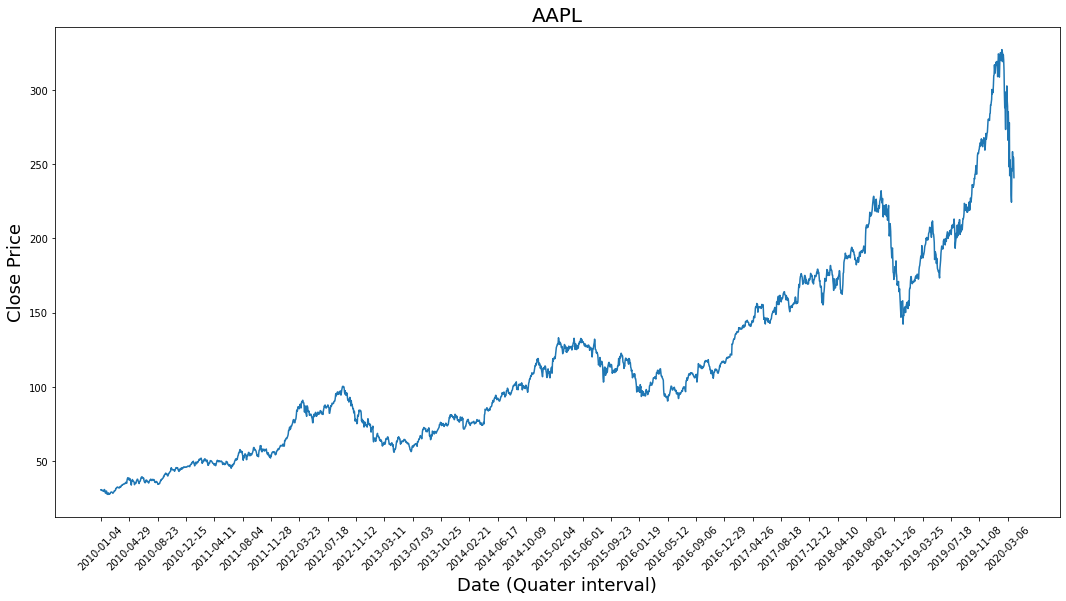

In [0]:
# Adapted from Thushan Ganegedara
plt.figure(figsize = (18,9))
plt.plot(range(aapl.shape[0]), aapl.Close)
plt.xticks(range(0,aapl.shape[0],80), aapl['Date'].dt.date.loc[::80],rotation=45)
plt.xlabel('Date (Quater interval)',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.title('AAPL', fontsize=20)
plt.show();

<a id='13'></a>
### Step 1.3: Engineering Features

In [0]:
# Drop the Date and Adj close columns
data = aapl.drop(['Date', 'Adj Close'], axis=1)
data.head()

,High,Low,Open,Close,Volume
0,30.642857,30.340000,30.490000,30.572857,123432400.0
1,30.798571,30.464285,30.657143,30.625713,150476200.0
2,30.747143,30.107143,30.625713,30.138571,138040000.0
3,30.285715,29.864286,30.250000,30.082857,119282800.0
4,30.285715,29.865715,30.042856,30.282858,111902700.0


<a id='14'></a>
### Step 1.4: Splitting the Data into train, valid and test set

In [0]:
def split_data(data, train_idx, valid_idx=None, test=False):
  """
  Split the data into train, test and/or valida set.
  """
  data = data.values
  if test:
    train_data = data[:train_idx, :]
    test_data = data[train_idx:, :]
    return train_data, test_data
  else:
    train_data = data[:train_idx, :]
    valid_data = data[train_idx:valid_idx, :]
    test_data = data[valid_idx:, :]
    return train_data, valid_data, test_data

In [0]:
# train data are approximately two and half years agao 
# valida data is about second recent 1 and half years 
# test data is about first recent 1 and half years till the end
train_data, valid_data, test_data = split_data(data, 2000, 2289)
print('train data:{:.2f}%'.format(train_data.shape[0] / len(aapl) * 100))
print('valid data:{:.2f}%'.format(valid_data.shape[0] / len(aapl) * 100))
print('test data:{:.2f}%'.format(test_data.shape[0] / len(aapl) * 100))

train data:77.55%
valid data:11.21%
test data:11.24%


<a id='15'></a>
### Step 1.5: Normalizing the Data

In [0]:
def normalize_data(train_data, valid_data=None, test_data=None, test=False):
  """
  MinMax normalize the train, test and/or valida set.
  """
  scaler = MinMaxScaler()
  train_data = scaler.fit_transform(train_data)

  if test:
    test_data =  scaler.transform(test_data)
    return scaler, train_data, test_data
  else:
    valid_data = scaler.transform(valid_data)
    test_data = scaler.transform(test_data)
    return scaler, train_data, valid_data, test_data

In [0]:
scaler, train_data, valid_data, test_data = normalize_data(train_data, valid_data, test_data)

In [0]:
# Normalized train data
pd.DataFrame(train_data, columns=list(data)).head(6)

,High,Low,Open,Close,Volume
0,0.017828,0.021438,0.020379,0.021082,0.244034
1,0.018879,0.022280,0.021512,0.021438,0.302982
2,0.018532,0.019859,0.021299,0.018164,0.275875
3,0.015419,0.018212,0.018754,0.017789,0.234989
4,0.015419,0.018221,0.017350,0.019133,0.218903
5,0.016383,0.017631,0.019770,0.017338,0.226869


<a id='16'></a>
### Step 1.6: Generating Timeseries Samples and their Targets

In [0]:
# Adapted from J. Brownlee
def split_sequence_mto(data, n_steps):
  """
  Split a sequence into many to one or one to one depending on the time setps.
  """
  X, Y = [], []
  for i in np.arange(len(data)):
    end_idx = i + n_steps
    # Check if the idx is out of bound
    if end_idx > len(data) - 1:
      break
    x, y = data[i:end_idx, :], data[end_idx, 3]
    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)

In [0]:
# Use the previous 4 days to predict the 5th days's price
n_steps, n_features = 4, 5
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

print('X_train shape:', X_train.shape)
print('y_train :', len(y_train))
print('X_valid shape:', X_valid.shape)
print('y_valid :', len(y_valid))
print('X_test shape:', X_test.shape)
print('y_test :', len(y_test))

X_train shape: (1996, 4, 5)
y_train : 1996
X_valid shape: (285, 4, 5)
y_valid : 285
X_test shape: (286, 4, 5)
y_test : 286


In [0]:
X_train[:2]

array([[[0.01782823, 0.02143757, 0.02037933, 0.02108234, 0.24403431],
        [0.01887865, 0.02228034, 0.02151152, 0.02143754, 0.30298234],
        [0.01853172, 0.01985857, 0.02129862, 0.01816383, 0.27587485],
        [0.01541902, 0.01821176, 0.01875363, 0.01778942, 0.23498933]],

       [[0.01887865, 0.02228034, 0.02151152, 0.02143754, 0.30298234],
        [0.01853172, 0.01985857, 0.02129862, 0.01816383, 0.27587485],
        [0.01541902, 0.01821176, 0.01875363, 0.01778942, 0.23498933],
        [0.01541902, 0.01822145, 0.01735049, 0.01913347, 0.21890274]]])

In [0]:
y_train[:2]

array([0.01913347, 0.01733821])

<a id='2'></a>
## Step 2: Developing a model

<a id='21'></a>
### Step 2.1: A Common-sense, Non-machine-learning Baseline

In [0]:
# Adapted from F. Chollet
# Always predict tomorrow's price using today's price
preds_y_valid = X_valid[:, 3, 3]
print('Normalized base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)))
print('Original base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)) * scaler.data_range_[3])

preds_y_test = X_test[:, 3, 3]
print('Normalized base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)))
print('Original base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)) * scaler.data_range_[3])

Normalized base line MAE on validation data: 0.01649334527045131
Original base line MAE on validation data: 2.4542805454187233
Normalized base line MAE on test data: 0.02410966908567308
Original base line MAE on test data: 3.5876222090287646


<a id='22'></a>
### Step 2.2: A FC Model

In [0]:
def eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test):
  """
  Print MAE on train, valid and test set.
  """
  preds_y_valid = X_valid[:, n_steps-1, 3]
  print('\nNormalized base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)))
  print('Original base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)) * scaler.data_range_[3])

  preds_y_test = X_test[:, n_steps-1, 3]
  print('Normalized base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)))
  print('Original base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)) * scaler.data_range_[3])

  print('Validation MAE:', model.evaluate(X_valid, y_valid)[1])
  print('Original validation MAE:', model.evaluate(X_valid, y_valid)[1] * scaler.data_range_[3])
  print('Test MAE:', model.evaluate(X_test, y_test)[1])
  print('Original test MAE:', model.evaluate(X_test, y_test)[1] * scaler.data_range_[3])

In [0]:
def plot_model(history, model, X_test, y_test):
  """
  Plot MAE, loss and predicted close price on test set.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = np.arange(1, len(loss) + 1)

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training mae')
  plt.plot(epochs, val_loss, 'b', label='Validation mae')
  plt.title('Training and validation mae')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  
  plt.figure()

  plt.plot(y_test, 'b', label='Actual')
  plt.plot(model.predict(X_test), 'r', label='Predictedt')
  plt.title('Actual vs. predicted close price on test set')
  plt.legend()
  plt.show();

Train on 1996 samples, validate on 285 samples
Epoch 1/200
1996/1996 [==============================] - 2s 976us/step - loss: 0.2011 - mae: 0.2011 - val_loss: 0.0743 - val_mae: 0.0743
Epoch 2/200
1996/1996 [==============================] - 0s 93us/step - loss: 0.1779 - mae: 0.1779 - val_loss: 0.0879 - val_mae: 0.0879
Epoch 3/200
1996/1996 [==============================] - 0s 78us/step - loss: 0.1630 - mae: 0.1630 - val_loss: 0.0842 - val_mae: 0.0842
Epoch 4/200
1996/1996 [==============================] - 0s 77us/step - loss: 0.1472 - mae: 0.1472 - val_loss: 0.0859 - val_mae: 0.0859
Epoch 5/200
1996/1996 [==============================] - 0s 80us/step - loss: 0.1295 - mae: 0.1295 - val_loss: 0.0523 - val_mae: 0.0523
Epoch 6/200
1996/1996 [==============================] - 0s 76us/step - loss: 0.1233 - mae: 0.1233 - val_loss: 0.0672 - val_mae: 0.0672
Epoch 7/200
1996/1996 [==============================] - 0s 76us/step - loss: 0.1152 - mae: 0.1152 - val_loss: 0.0806 - val_mae: 0.0806


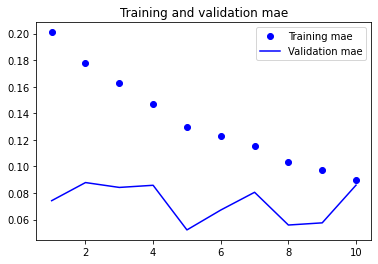

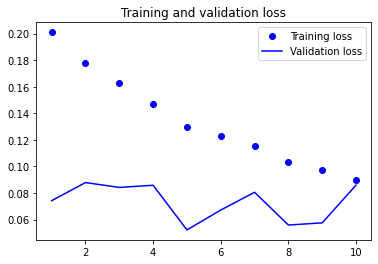

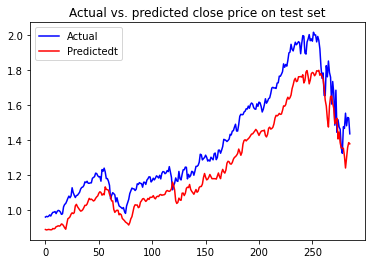

In [0]:
# MLP model
model = Sequential()
model.add(layers.Flatten(input_shape=(n_steps, n_features)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='23'></a>
### Step 2.3: A GRU Model

Train on 1996 samples, validate on 285 samples
Epoch 1/200
1996/1996 [==============================] - 1s 598us/step - loss: 0.5047 - mae: 0.5047 - val_loss: 0.9933 - val_mae: 0.9933
Epoch 2/200
1996/1996 [==============================] - 1s 430us/step - loss: 0.1663 - mae: 0.1663 - val_loss: 0.4491 - val_mae: 0.4491
Epoch 3/200
1996/1996 [==============================] - 1s 439us/step - loss: 0.0885 - mae: 0.0885 - val_loss: 0.3999 - val_mae: 0.3999
Epoch 4/200
1996/1996 [==============================] - 1s 376us/step - loss: 0.0761 - mae: 0.0761 - val_loss: 0.3603 - val_mae: 0.3603
Epoch 5/200
1996/1996 [==============================] - 1s 383us/step - loss: 0.0706 - mae: 0.0706 - val_loss: 0.3352 - val_mae: 0.3352
Epoch 6/200
1996/1996 [==============================] - 1s 402us/step - loss: 0.0627 - mae: 0.0627 - val_loss: 0.3026 - val_mae: 0.3026
Epoch 7/200
1996/1996 [==============================] - 1s 438us/step - loss: 0.0613 - mae: 0.0613 - val_loss: 0.3039 - val_mae: 0

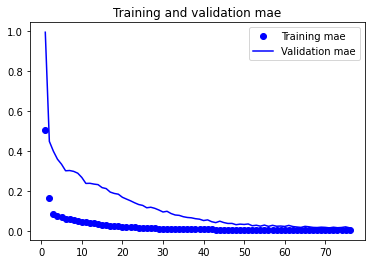

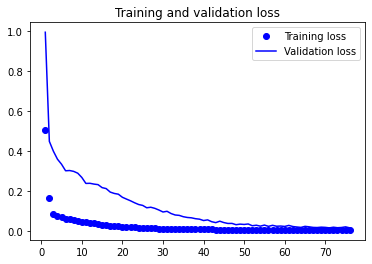

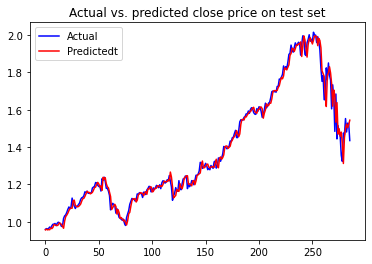

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='24'></a>
### Step 2.4: A LSTM Model

Train on 1996 samples, validate on 285 samples
Epoch 1/200
1996/1996 [==============================] - 1s 473us/step - loss: 0.2359 - mae: 0.2359 - val_loss: 0.3969 - val_mae: 0.3969
Epoch 2/200
1996/1996 [==============================] - 1s 341us/step - loss: 0.0547 - mae: 0.0547 - val_loss: 0.0956 - val_mae: 0.0956
Epoch 3/200
1996/1996 [==============================] - 1s 347us/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0560 - val_mae: 0.0560
Epoch 4/200
1996/1996 [==============================] - 1s 370us/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0416 - val_mae: 0.0416
Epoch 5/200
1996/1996 [==============================] - 1s 335us/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 6/200
1996/1996 [==============================] - 1s 307us/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0398 - val_mae: 0.0398
Epoch 7/200
1996/1996 [==============================] - 1s 322us/step - loss: 0.0178 - mae: 0.0178 - val_loss: 0.0311 - val_mae: 0

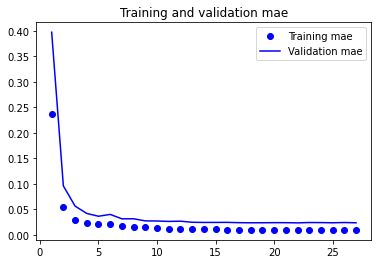

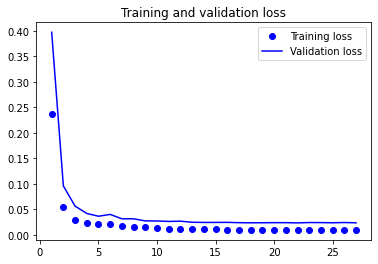

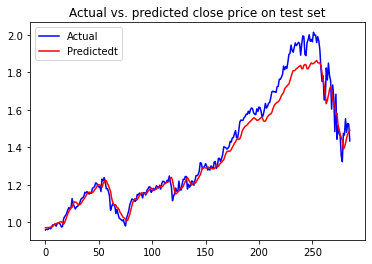

In [0]:
# LSTM model
model = Sequential()
model.add(layers.LSTM(64, recurrent_dropout=0.5, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='31'></a>
### Step 2.5: A GRU Model with attention layer



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 4, 128)            26880     
_________________________________________________________________
gru_3 (GRU)                  (None, 4, 64)             37056     
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, 4, 64)             4161      
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 68,354
Trainable params: 68,354
Non-trainable params: 0
_________________________________________________________________
Train on 1996 samples, validate on 285 samples
Epoch 1/200
1996/1996 [==============================] - 3s 2ms/step 

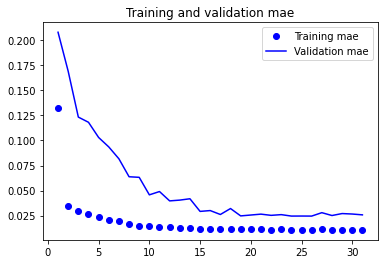

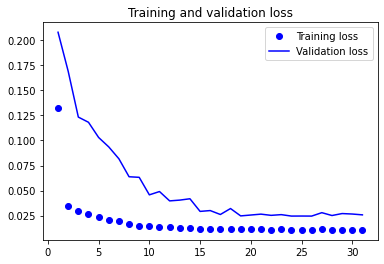

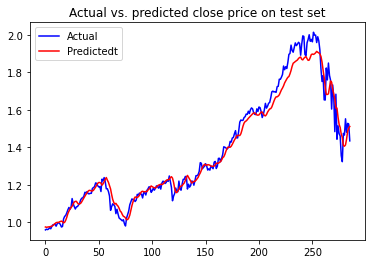

In [0]:
# GRU model with attention layer
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(64, recurrent_dropout=0.5, return_sequences=True), input_shape=(n_steps, n_features)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(layers.Flatten())
model.add(layers.Dense(1))
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='31'></a>
### Step 2.6: A LSTM Model with attention layer


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 4, 128)            35840     
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 64)             49408     
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, 4, 64)             4161      
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 89,666
Trainable params: 89,666
Non-trainable params: 0
_________________________________________________________________
Train on 1996 samples, validate on 285 samples
Epoch 1/200
1996/1996 [==============================] - 3s 1ms/step 

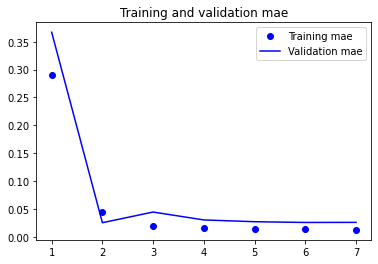

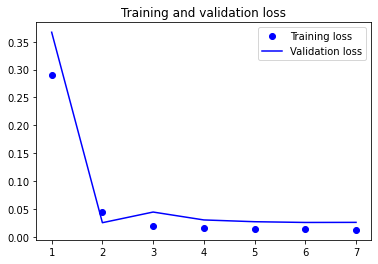

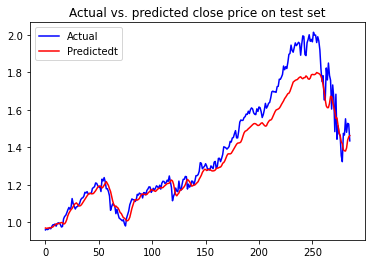

In [0]:
# LSTM model with attention layer
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(64, recurrent_dropout=0.5, return_sequences=True), input_shape=(n_steps, n_features)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(layers.Flatten())
model.add(layers.Dense(1))
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='3'></a>
## Step 3: Optimizing the Model

<a id='31'></a>
### Step 3.1: Using Ten Days Lags

In [0]:
# Use the previous 10 days to predict the 11th day's price
n_steps = 10
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

Train on 1990 samples, validate on 279 samples
Epoch 1/200
1990/1990 [==============================] - 0s 133us/step - loss: 0.2459 - mae: 0.2459 - val_loss: 0.0425 - val_mae: 0.0425
Epoch 2/200
1990/1990 [==============================] - 0s 92us/step - loss: 0.1883 - mae: 0.1883 - val_loss: 0.0512 - val_mae: 0.0512
Epoch 3/200
1990/1990 [==============================] - 0s 98us/step - loss: 0.1679 - mae: 0.1679 - val_loss: 0.0856 - val_mae: 0.0856
Epoch 4/200
1990/1990 [==============================] - 0s 102us/step - loss: 0.1422 - mae: 0.1422 - val_loss: 0.0363 - val_mae: 0.0363
Epoch 5/200
1990/1990 [==============================] - 0s 88us/step - loss: 0.1227 - mae: 0.1227 - val_loss: 0.0520 - val_mae: 0.0520
Epoch 6/200
1990/1990 [==============================] - 0s 80us/step - loss: 0.1089 - mae: 0.1089 - val_loss: 0.0482 - val_mae: 0.0482
Epoch 7/200
1990/1990 [==============================] - 0s 85us/step - loss: 0.1020 - mae: 0.1020 - val_loss: 0.0682 - val_mae: 0.0682

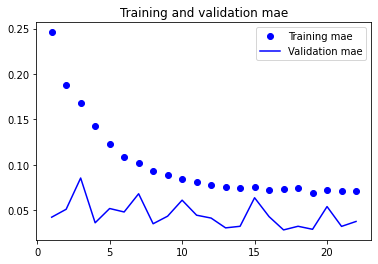

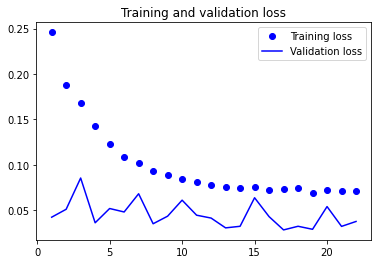

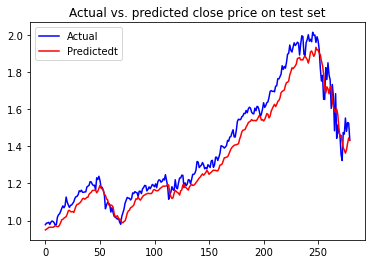

In [0]:
# MLP model
model = Sequential()
model.add(layers.Flatten(input_shape=(n_steps, n_features)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 1990 samples, validate on 279 samples
Epoch 1/200
1990/1990 [==============================] - 2s 1ms/step - loss: 0.2258 - mae: 0.2258 - val_loss: 0.7607 - val_mae: 0.7607
Epoch 2/200
1990/1990 [==============================] - 1s 748us/step - loss: 0.1317 - mae: 0.1317 - val_loss: 0.7185 - val_mae: 0.7185
Epoch 3/200
1990/1990 [==============================] - 2s 802us/step - loss: 0.1002 - mae: 0.1002 - val_loss: 0.6659 - val_mae: 0.6659
Epoch 4/200
1990/1990 [==============================] - 2s 859us/step - loss: 0.0840 - mae: 0.0840 - val_loss: 0.6142 - val_mae: 0.6142
Epoch 5/200
1990/1990 [==============================] - 2s 914us/step - loss: 0.0717 - mae: 0.0717 - val_loss: 0.5799 - val_mae: 0.5799
Epoch 6/200
1990/1990 [==============================] - 2s 850us/step - loss: 0.0630 - mae: 0.0630 - val_loss: 0.5537 - val_mae: 0.5537
Epoch 7/200
1990/1990 [==============================] - 2s 759us/step - loss: 0.0527 - mae: 0.0527 - val_loss: 0.5343 - val_mae: 0.5

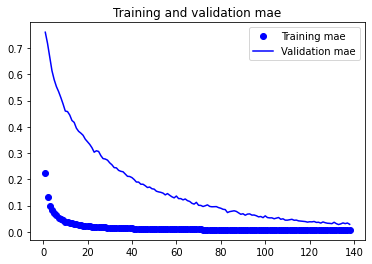

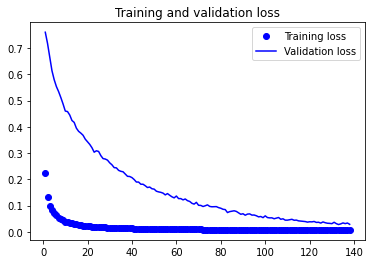

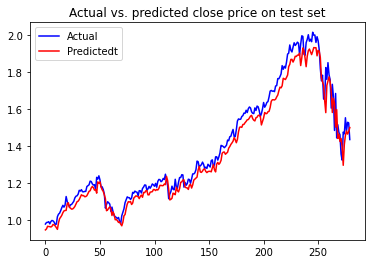

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 1990 samples, validate on 279 samples
Epoch 1/200
1990/1990 [==============================] - 2s 803us/step - loss: 0.2797 - mae: 0.2797 - val_loss: 0.3548 - val_mae: 0.3548
Epoch 2/200
1990/1990 [==============================] - 1s 628us/step - loss: 0.0679 - mae: 0.0679 - val_loss: 0.1523 - val_mae: 0.1523
Epoch 3/200
1990/1990 [==============================] - 1s 632us/step - loss: 0.0498 - mae: 0.0498 - val_loss: 0.0950 - val_mae: 0.0950
Epoch 4/200
1990/1990 [==============================] - 1s 637us/step - loss: 0.0415 - mae: 0.0415 - val_loss: 0.0669 - val_mae: 0.0669
Epoch 5/200
1990/1990 [==============================] - 1s 624us/step - loss: 0.0351 - mae: 0.0351 - val_loss: 0.0565 - val_mae: 0.0565
Epoch 6/200
1990/1990 [==============================] - 1s 631us/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0523 - val_mae: 0.0523
Epoch 7/200
1990/1990 [==============================] - 1s 637us/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0465 - val_mae: 0

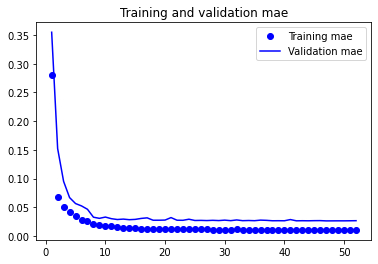

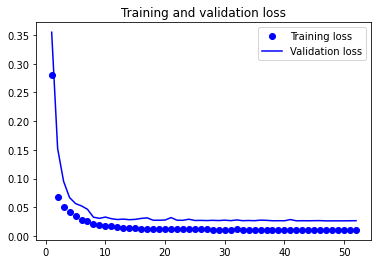

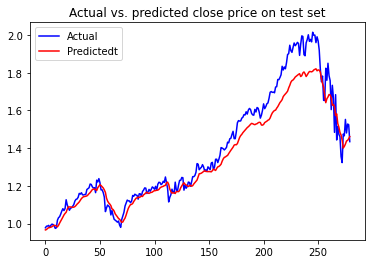

In [0]:
# LSTM model
model = Sequential()
model.add(layers.LSTM(64, recurrent_dropout=0.5, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='32'></a>
### Step 3.2: Using One Day Lag

In [0]:
# Use the previous 1 days to predict the 2nd day's price
n_steps = 1
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

Train on 1999 samples, validate on 288 samples
Epoch 1/200
1999/1999 [==============================] - 0s 129us/step - loss: 0.3784 - mae: 0.3784 - val_loss: 1.0084 - val_mae: 1.0084
Epoch 2/200
1999/1999 [==============================] - 0s 84us/step - loss: 0.2911 - mae: 0.2911 - val_loss: 0.8117 - val_mae: 0.8117
Epoch 3/200
1999/1999 [==============================] - 0s 75us/step - loss: 0.2261 - mae: 0.2261 - val_loss: 0.6419 - val_mae: 0.6419
Epoch 4/200
1999/1999 [==============================] - 0s 79us/step - loss: 0.1834 - mae: 0.1834 - val_loss: 0.5119 - val_mae: 0.5119
Epoch 5/200
1999/1999 [==============================] - 0s 76us/step - loss: 0.1582 - mae: 0.1582 - val_loss: 0.4144 - val_mae: 0.4144
Epoch 6/200
1999/1999 [==============================] - 0s 78us/step - loss: 0.1466 - mae: 0.1466 - val_loss: 0.3420 - val_mae: 0.3420
Epoch 7/200
1999/1999 [==============================] - 0s 77us/step - loss: 0.1403 - mae: 0.1403 - val_loss: 0.2967 - val_mae: 0.2967


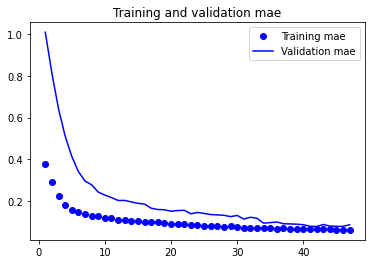

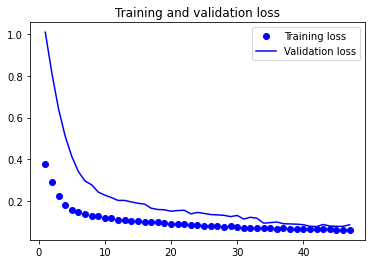

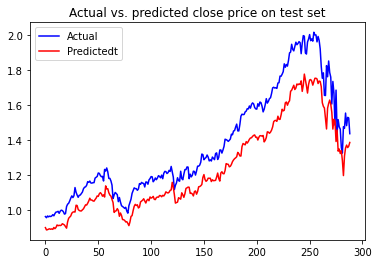

In [0]:
# MLP model
model = Sequential()
model.add(layers.Flatten(input_shape=(n_steps, n_features)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 1999 samples, validate on 288 samples
Epoch 1/200
1999/1999 [==============================] - 1s 369us/step - loss: 0.3125 - mae: 0.3125 - val_loss: 0.7249 - val_mae: 0.7249
Epoch 2/200
1999/1999 [==============================] - 0s 191us/step - loss: 0.2143 - mae: 0.2143 - val_loss: 0.5231 - val_mae: 0.5231
Epoch 3/200
1999/1999 [==============================] - 0s 184us/step - loss: 0.1275 - mae: 0.1275 - val_loss: 0.3232 - val_mae: 0.3232
Epoch 4/200
1999/1999 [==============================] - 0s 188us/step - loss: 0.0689 - mae: 0.0689 - val_loss: 0.1652 - val_mae: 0.1652
Epoch 5/200
1999/1999 [==============================] - 0s 185us/step - loss: 0.0441 - mae: 0.0441 - val_loss: 0.0995 - val_mae: 0.0995
Epoch 6/200
1999/1999 [==============================] - 0s 180us/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0678 - val_mae: 0.0678
Epoch 7/200
1999/1999 [==============================] - 0s 192us/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0352 - val_mae: 0

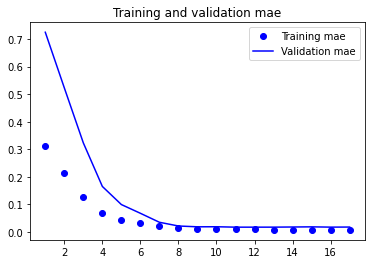

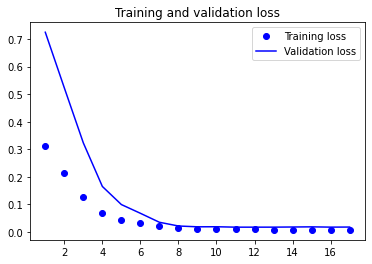

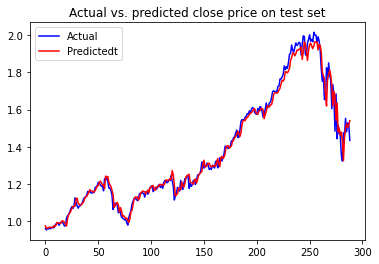

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 1999 samples, validate on 288 samples
Epoch 1/200
1999/1999 [==============================] - 1s 353us/step - loss: 0.3283 - mae: 0.3283 - val_loss: 0.8069 - val_mae: 0.8069
Epoch 2/200
1999/1999 [==============================] - 0s 167us/step - loss: 0.2654 - mae: 0.2654 - val_loss: 0.6746 - val_mae: 0.6746
Epoch 3/200
1999/1999 [==============================] - 0s 166us/step - loss: 0.2027 - mae: 0.2027 - val_loss: 0.5319 - val_mae: 0.5319
Epoch 4/200
1999/1999 [==============================] - 0s 212us/step - loss: 0.1415 - mae: 0.1415 - val_loss: 0.3809 - val_mae: 0.3809
Epoch 5/200
1999/1999 [==============================] - 0s 194us/step - loss: 0.0908 - mae: 0.0908 - val_loss: 0.2348 - val_mae: 0.2348
Epoch 6/200
1999/1999 [==============================] - 0s 188us/step - loss: 0.0578 - mae: 0.0578 - val_loss: 0.1210 - val_mae: 0.1210
Epoch 7/200
1999/1999 [==============================] - 0s 164us/step - loss: 0.0423 - mae: 0.0423 - val_loss: 0.0714 - val_mae: 0

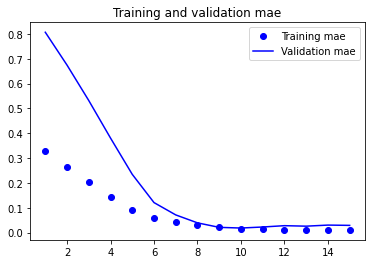

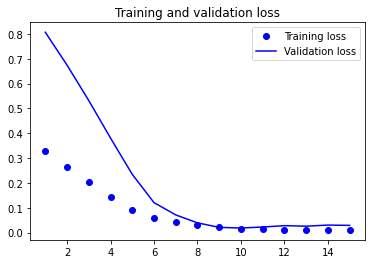

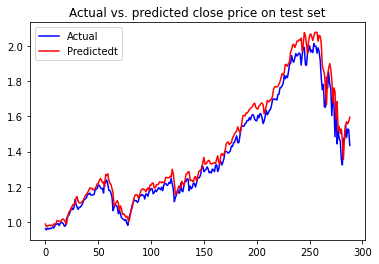

In [0]:
# LSTM model
model = Sequential()
model.add(layers.LSTM(64, recurrent_dropout=0.5, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='33'></a>
### Step 3.3: Using Twnety Days Lags

In [0]:
# Use the previous 20 days to predict the 21th day's price
n_steps = 20
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

Train on 1980 samples, validate on 269 samples
Epoch 1/200
1980/1980 [==============================] - 0s 152us/step - loss: 0.4909 - mae: 0.4909 - val_loss: 0.1612 - val_mae: 0.1612
Epoch 2/200
1980/1980 [==============================] - 0s 81us/step - loss: 0.3083 - mae: 0.3083 - val_loss: 0.1390 - val_mae: 0.1390
Epoch 3/200
1980/1980 [==============================] - 0s 83us/step - loss: 0.2631 - mae: 0.2631 - val_loss: 0.0526 - val_mae: 0.0526
Epoch 4/200
1980/1980 [==============================] - 0s 80us/step - loss: 0.2032 - mae: 0.2032 - val_loss: 0.0481 - val_mae: 0.0481
Epoch 5/200
1980/1980 [==============================] - 0s 88us/step - loss: 0.1558 - mae: 0.1558 - val_loss: 0.0648 - val_mae: 0.0648
Epoch 6/200
1980/1980 [==============================] - 0s 81us/step - loss: 0.1224 - mae: 0.1224 - val_loss: 0.0956 - val_mae: 0.0956
Epoch 7/200
1980/1980 [==============================] - 0s 79us/step - loss: 0.1004 - mae: 0.1004 - val_loss: 0.0709 - val_mae: 0.0709


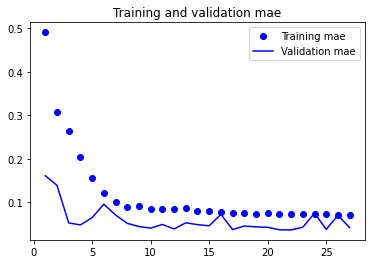

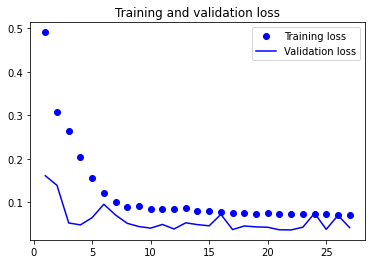

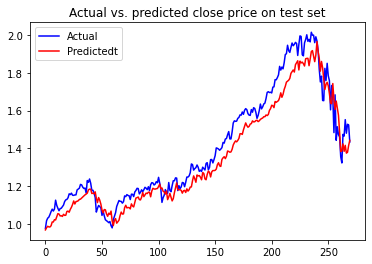

In [0]:
# MLP model
model = Sequential()
model.add(layers.Flatten(input_shape=(n_steps, n_features)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 1980 samples, validate on 269 samples
Epoch 1/200
1980/1980 [==============================] - 3s 2ms/step - loss: 0.8807 - mae: 0.8807 - val_loss: 1.3264 - val_mae: 1.3264
Epoch 2/200
1980/1980 [==============================] - 3s 2ms/step - loss: 0.4104 - mae: 0.4104 - val_loss: 1.2430 - val_mae: 1.2430
Epoch 3/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.2820 - mae: 0.2820 - val_loss: 1.1768 - val_mae: 1.1768
Epoch 4/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.2360 - mae: 0.2360 - val_loss: 1.1254 - val_mae: 1.1254
Epoch 5/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.1868 - mae: 0.1868 - val_loss: 1.0745 - val_mae: 1.0745
Epoch 6/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.1573 - mae: 0.1573 - val_loss: 1.0341 - val_mae: 1.0341
Epoch 7/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.1478 - mae: 0.1478 - val_loss: 1.0013 - val_mae: 1.0013
Epoch 8/

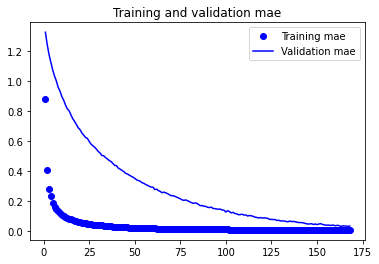

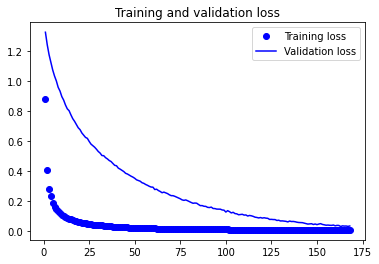

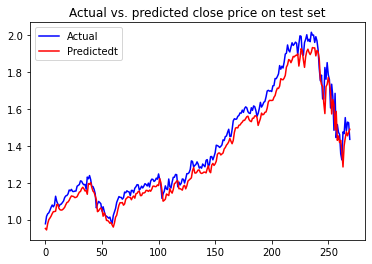

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 1980 samples, validate on 269 samples
Epoch 1/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.1896 - mae: 0.1896 - val_loss: 0.1652 - val_mae: 0.1652
Epoch 2/200
1980/1980 [==============================] - 2s 1ms/step - loss: 0.0632 - mae: 0.0632 - val_loss: 0.0914 - val_mae: 0.0914
Epoch 3/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.0465 - mae: 0.0465 - val_loss: 0.0558 - val_mae: 0.0558
Epoch 4/200
1980/1980 [==============================] - 2s 1ms/step - loss: 0.0373 - mae: 0.0373 - val_loss: 0.0470 - val_mae: 0.0470
Epoch 5/200
1980/1980 [==============================] - 2s 1ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0405 - val_mae: 0.0405
Epoch 6/200
1980/1980 [==============================] - 3s 1ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0399 - val_mae: 0.0399
Epoch 7/200
1980/1980 [==============================] - 2s 1ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0401 - val_mae: 0.0401
Epoch 8/

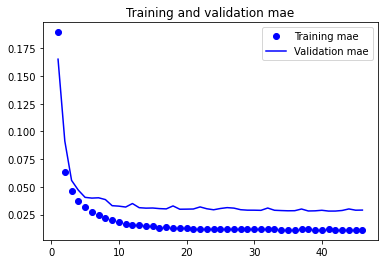

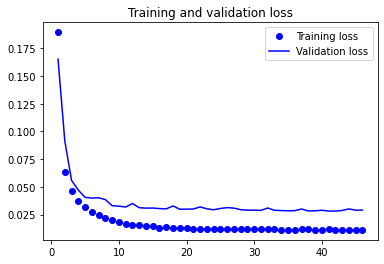

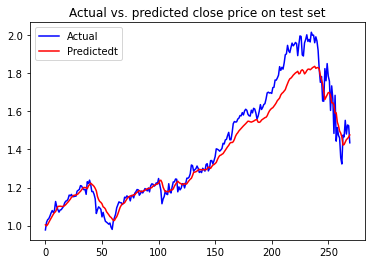

In [0]:
# LSTM model
model = Sequential()
model.add(layers.LSTM(64, recurrent_dropout=0.5, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='34'></a>
### Step 3.4: Optimizing GRU Model

<a id='341'></a>
####  Step 3.4.1: Optimizing GRU Model on One Day Lag

In [0]:
# train data are approximately half years agao 
# valida data is about half years ago to three months ago 
# test data is about three months till the end
train_data, valid_data, test_data = split_data(data, 2459, 2519)

In [0]:
scaler, train_data, valid_data, test_data = normalize_data(train_data, valid_data, test_data)

In [0]:
n_steps = 1
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

Train on 2458 samples, validate on 59 samples
Epoch 1/200
2458/2458 [==============================] - 1s 391us/step - loss: 0.3140 - mae: 0.3140 - val_loss: 0.8595 - val_mae: 0.8595
Epoch 2/200
2458/2458 [==============================] - 0s 175us/step - loss: 0.1966 - mae: 0.1966 - val_loss: 0.5770 - val_mae: 0.5770
Epoch 3/200
2458/2458 [==============================] - 0s 186us/step - loss: 0.1132 - mae: 0.1132 - val_loss: 0.3355 - val_mae: 0.3355
Epoch 4/200
2458/2458 [==============================] - 0s 195us/step - loss: 0.0685 - mae: 0.0685 - val_loss: 0.1865 - val_mae: 0.1865
Epoch 5/200
2458/2458 [==============================] - 1s 249us/step - loss: 0.0443 - mae: 0.0443 - val_loss: 0.1146 - val_mae: 0.1146
Epoch 6/200
2458/2458 [==============================] - 1s 243us/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0538 - val_mae: 0.0538
Epoch 7/200
2458/2458 [==============================] - 0s 181us/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0214 - val_mae: 0.

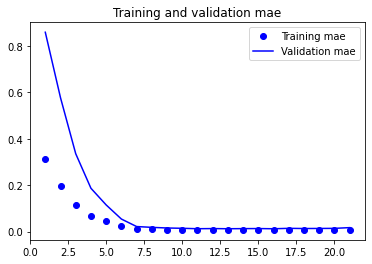

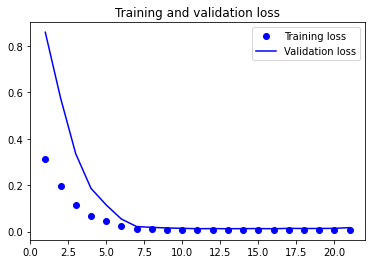

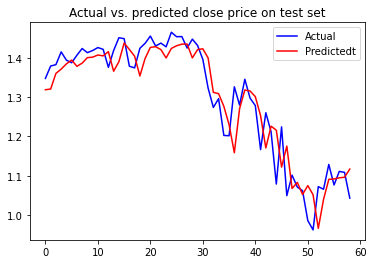

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='342'></a>
#### Step 3.4.2: Optimizing GRU Model on Four Days Lags

In [0]:
n_steps = 4
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

Train on 2455 samples, validate on 56 samples
Epoch 1/200
2455/2455 [==============================] - 1s 578us/step - loss: 0.1278 - mae: 0.1278 - val_loss: 0.3985 - val_mae: 0.3985
Epoch 2/200
2455/2455 [==============================] - 1s 389us/step - loss: 0.0766 - mae: 0.0766 - val_loss: 0.3131 - val_mae: 0.3131
Epoch 3/200
2455/2455 [==============================] - 1s 369us/step - loss: 0.0666 - mae: 0.0666 - val_loss: 0.2881 - val_mae: 0.2881
Epoch 4/200
2455/2455 [==============================] - 1s 376us/step - loss: 0.0597 - mae: 0.0597 - val_loss: 0.3059 - val_mae: 0.3059
Epoch 5/200
2455/2455 [==============================] - 1s 374us/step - loss: 0.0529 - mae: 0.0529 - val_loss: 0.2915 - val_mae: 0.2915
Epoch 6/200
2455/2455 [==============================] - 1s 387us/step - loss: 0.0463 - mae: 0.0463 - val_loss: 0.2490 - val_mae: 0.2490
Epoch 7/200
2455/2455 [==============================] - 1s 493us/step - loss: 0.0403 - mae: 0.0403 - val_loss: 0.2363 - val_mae: 0.

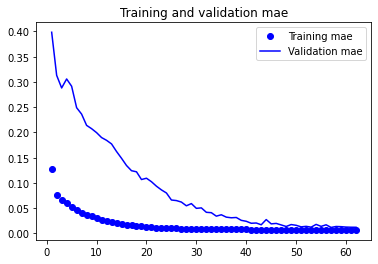

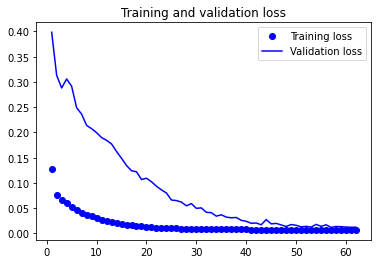

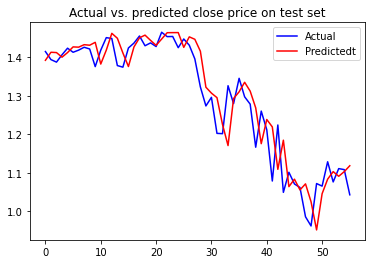

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='343'></a>
#### Step 3.4.3: Optimizing GRU Model on Ten Days Lags

In [0]:
n_steps = 10
X_train, y_train = split_sequence_mto(train_data, n_steps)
X_valid, y_valid = split_sequence_mto(valid_data, n_steps)
X_test, y_test = split_sequence_mto(test_data, n_steps)

Train on 2449 samples, validate on 50 samples
Epoch 1/200
2449/2449 [==============================] - 2s 973us/step - loss: 0.2233 - mae: 0.2233 - val_loss: 0.7045 - val_mae: 0.7045
Epoch 2/200
2449/2449 [==============================] - 2s 834us/step - loss: 0.1318 - mae: 0.1318 - val_loss: 0.6612 - val_mae: 0.6612
Epoch 3/200
2449/2449 [==============================] - 2s 723us/step - loss: 0.1050 - mae: 0.1050 - val_loss: 0.6264 - val_mae: 0.6264
Epoch 4/200
2449/2449 [==============================] - 2s 786us/step - loss: 0.0784 - mae: 0.0784 - val_loss: 0.6082 - val_mae: 0.6082
Epoch 5/200
2449/2449 [==============================] - 2s 757us/step - loss: 0.0688 - mae: 0.0688 - val_loss: 0.5732 - val_mae: 0.5732
Epoch 6/200
2449/2449 [==============================] - 2s 832us/step - loss: 0.0566 - mae: 0.0566 - val_loss: 0.5574 - val_mae: 0.5574
Epoch 7/200
2449/2449 [==============================] - 2s 871us/step - loss: 0.0508 - mae: 0.0508 - val_loss: 0.5149 - val_mae: 0.

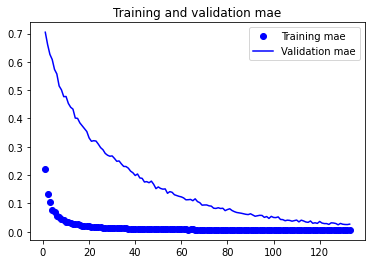

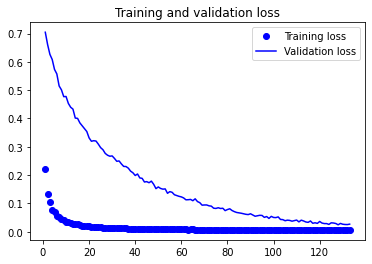

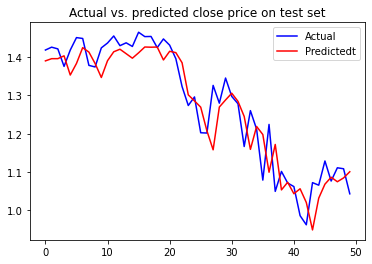

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae(model, scaler, n_steps, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='344'></a>
#### Step 3.4.4:Best Many-to-One GRU Model with Four Days Lags & One Day Delay

In [0]:
def load_data(ticker='AAPL', start=datetime.date(2010, 1, 1), end=datetime.date.today(),  n_steps=4):
  """
  Load the ticker data from start date to end date.
  Transform and normalize the dataset.
  """
  df = load_stock(ticker, start, end)
  data = df.drop(['Date', 'Adj Close'], axis=1)
  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)
  X_train, y_train = split_sequence_mto(data, n_steps)

  return scaler, X_train, y_train

In [0]:
scaler, X_train, y_train = load_data()
n_steps = 4
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
model.fit(X_train, y_train, epochs=62, verbose=0)

In [0]:
y_pred = model.predict(X_train[-1:, :])
print('Predicted price on {}: {}'.format(datetime.date.today(), y_pred * scaler.data_range_[3] + scaler.data_min_[3]))

Predicted price on 2020-04-25: [[272.16605]]


<a id='4'></a>
## Step 4: Many-to-Many Modeling

<a id='41'></a>
### Step 4.1: Developing a 4-to-4 Model

In [0]:
# Adapted from J. Brownlee
def split_sequence_mtm(data, n_steps_in, n_steps_out):
  """
  Split a sequence into many to many or one to many depending on the time setps.
  """
  X, Y = [], []
  for i in np.arange(len(data)):
    input_end_idx = i + n_steps_in
    output_end_idx = input_end_idx + n_steps_out
    # Check if the idx is out of bound
    if output_end_idx > len(data) - 1:
      break
    x, y = data[i:input_end_idx, :], data[input_end_idx:output_end_idx, 3]
    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)

In [0]:
# Prepare the data
train_data, valid_data, test_data = split_data(data, 2459, 2519)

scaler, train_data, valid_data, test_data = normalize_data(train_data, valid_data, test_data)

n_steps_in, n_steps_out, n_features = 4, 4, 5
X_train, y_train = split_sequence_mtm(train_data, n_steps_in, n_steps_out)
X_valid, y_valid = split_sequence_mtm(valid_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence_mtm(test_data, n_steps_in, n_steps_out)


In [0]:
def eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test):
  """
  Print MAE on train, valid and test set.
  """
  preds_y_valid = X_valid[:, -n_steps_out:, 3]
  print('\nNormalized base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)))
  print('Original base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)) * scaler.data_range_[3])

  preds_y_test = X_test[:, -n_steps_out:, 3]
  print('Normalized base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)))
  print('Original base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)) * scaler.data_range_[3])

  print('Validation MAE:', model.evaluate(X_valid, y_valid)[1])
  print('Original validation MAE:', model.evaluate(X_valid, y_valid)[1] * scaler.data_range_[3])
  print('Test MAE:', model.evaluate(X_test, y_test)[1])
  print('Original test MAE:', model.evaluate(X_test, y_test)[1] * scaler.data_range_[3])

In [0]:
# Very-common base-line model
# Always use today's price as predicted price for tomorrow
preds_y_valid = X_valid[:, -n_steps_out:, 3]
print('Normalized base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)))
print('Original base line MAE on validation data:', np.mean(np.abs(preds_y_valid - y_valid)) * scaler.data_range_[3])

preds_y_test = X_test[:, -n_steps_out:, 3]
print('Normalized base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)))
print('Original base line MAE on test data:', np.mean(np.abs(preds_y_test - y_test)) * scaler.data_range_[3])

Normalized base line MAE on validation data: 0.026264724310142637
Original base line MAE on validation data: 5.374663279606749
Normalized base line MAE on test data: 0.06180586094611616
Original base line MAE on test data: 12.647598633399376


Train on 2451 samples, validate on 52 samples
Epoch 1/200
2451/2451 [==============================] - 0s 123us/step - loss: 0.3334 - mae: 0.3334 - val_loss: 0.6616 - val_mae: 0.6616
Epoch 2/200
2451/2451 [==============================] - 0s 83us/step - loss: 0.2453 - mae: 0.2453 - val_loss: 0.4012 - val_mae: 0.4012
Epoch 3/200
2451/2451 [==============================] - 0s 82us/step - loss: 0.2070 - mae: 0.2070 - val_loss: 0.2648 - val_mae: 0.2648
Epoch 4/200
2451/2451 [==============================] - 0s 86us/step - loss: 0.1844 - mae: 0.1844 - val_loss: 0.2108 - val_mae: 0.2108
Epoch 5/200
2451/2451 [==============================] - 0s 88us/step - loss: 0.1672 - mae: 0.1672 - val_loss: 0.1998 - val_mae: 0.1998
Epoch 6/200
2451/2451 [==============================] - 0s 105us/step - loss: 0.1537 - mae: 0.1537 - val_loss: 0.1955 - val_mae: 0.1955
Epoch 7/200
2451/2451 [==============================] - 0s 89us/step - loss: 0.1399 - mae: 0.1399 - val_loss: 0.1760 - val_mae: 0.1760


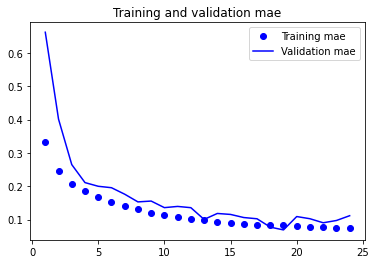

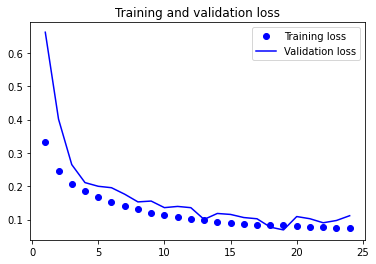

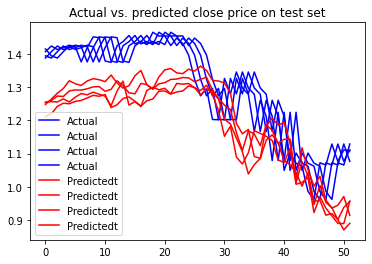

In [0]:
# MLP model
model = Sequential()
model.add(layers.Flatten(input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 2451 samples, validate on 52 samples
Epoch 1/200
2451/2451 [==============================] - 1s 523us/step - loss: 0.2929 - mae: 0.2929 - val_loss: 0.7647 - val_mae: 0.7647
Epoch 2/200
2451/2451 [==============================] - 1s 364us/step - loss: 0.1295 - mae: 0.1295 - val_loss: 0.4621 - val_mae: 0.4621
Epoch 3/200
2451/2451 [==============================] - 1s 371us/step - loss: 0.0785 - mae: 0.0785 - val_loss: 0.3794 - val_mae: 0.3794
Epoch 4/200
2451/2451 [==============================] - 1s 366us/step - loss: 0.0670 - mae: 0.0670 - val_loss: 0.3346 - val_mae: 0.3346
Epoch 5/200
2451/2451 [==============================] - 1s 366us/step - loss: 0.0601 - mae: 0.0601 - val_loss: 0.3001 - val_mae: 0.3001
Epoch 6/200
2451/2451 [==============================] - 1s 408us/step - loss: 0.0564 - mae: 0.0564 - val_loss: 0.2800 - val_mae: 0.2800
Epoch 7/200
2451/2451 [==============================] - 1s 366us/step - loss: 0.0513 - mae: 0.0513 - val_loss: 0.2694 - val_mae: 0.

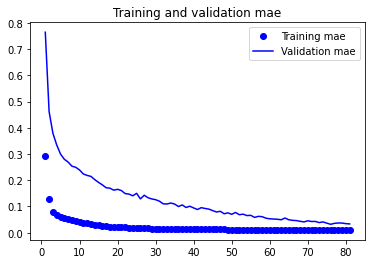

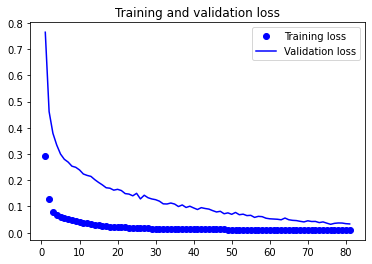

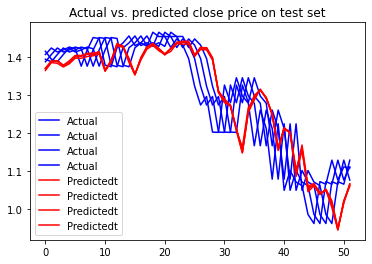

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Train on 2451 samples, validate on 52 samples
Epoch 1/200
2451/2451 [==============================] - 1s 480us/step - loss: 0.3241 - mae: 0.3241 - val_loss: 0.8579 - val_mae: 0.8579
Epoch 2/200
2451/2451 [==============================] - 1s 327us/step - loss: 0.1840 - mae: 0.1840 - val_loss: 0.3857 - val_mae: 0.3857
Epoch 3/200
2451/2451 [==============================] - 1s 318us/step - loss: 0.0623 - mae: 0.0623 - val_loss: 0.1362 - val_mae: 0.1362
Epoch 4/200
2451/2451 [==============================] - 1s 322us/step - loss: 0.0448 - mae: 0.0448 - val_loss: 0.0743 - val_mae: 0.0743
Epoch 5/200
2451/2451 [==============================] - 1s 316us/step - loss: 0.0356 - mae: 0.0356 - val_loss: 0.0421 - val_mae: 0.0421
Epoch 6/200
2451/2451 [==============================] - 1s 340us/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0303 - val_mae: 0.0303
Epoch 7/200
2451/2451 [==============================] - 1s 430us/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0266 - val_mae: 0.

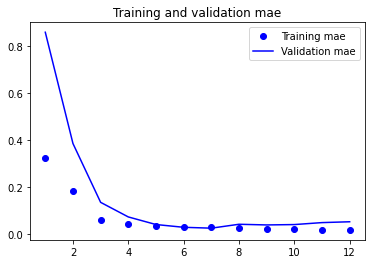

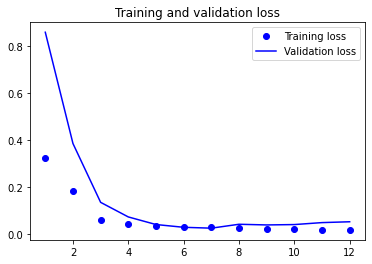

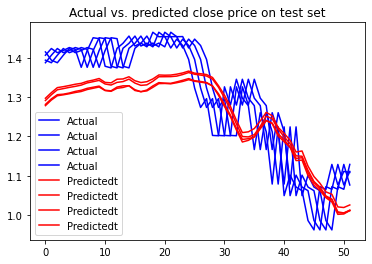

In [0]:
# LSTM model
model = Sequential()
model.add(layers.LSTM(64, recurrent_dropout=0.5, input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 4, 128)            26880     
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, 4, 128)            8257      
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 37,189
Trainable params: 37,189
Non-trainable params: 0
_________________________________________________________________
Train on 2451 samples, validate on 52 samples
Epoch 1/200
2451/2451 [==============================] - 3s 1ms/step - loss: 0.1972 - mae: 0.1972 - val_loss: 0.3139 - val_mae: 0.3139
Epoch 2/200
2451/2451 [==============================] - 2s 726us/s

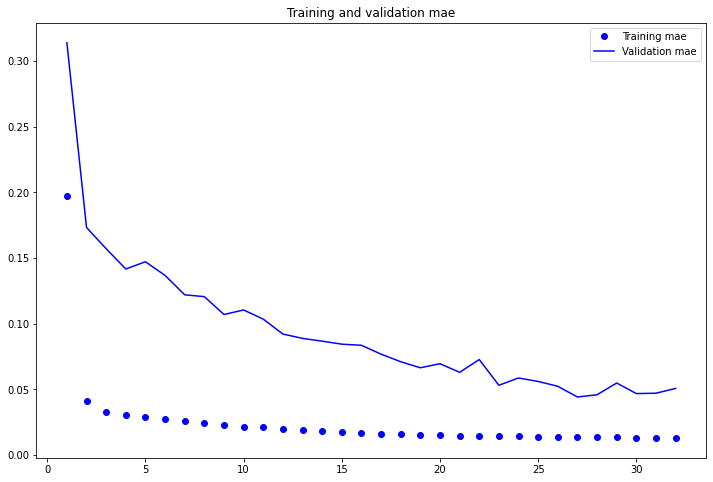

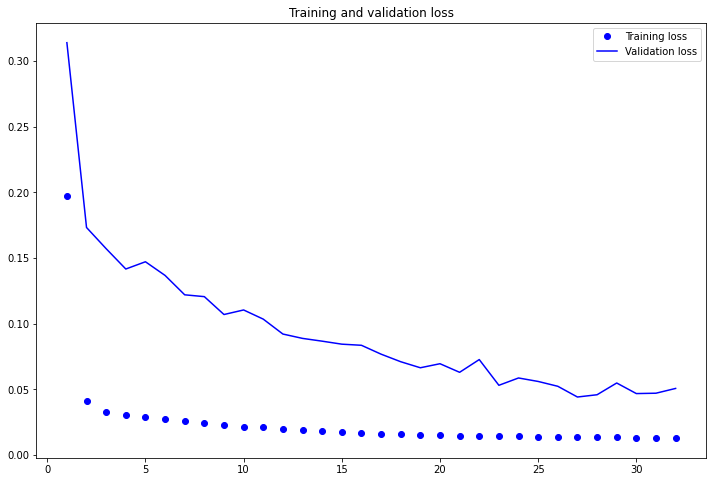

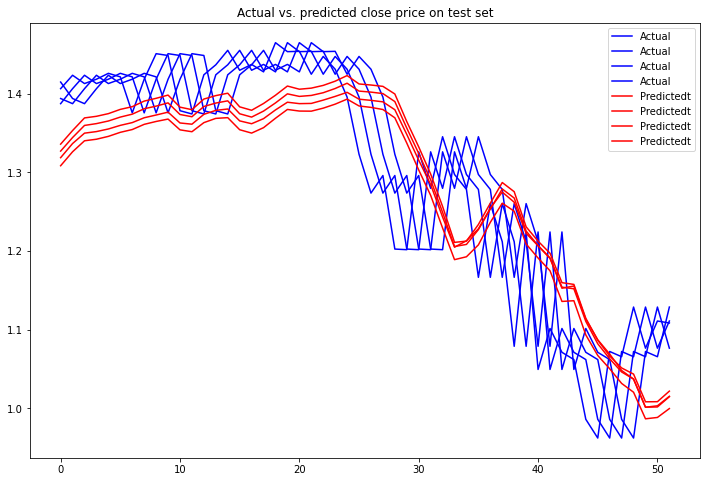

In [0]:
# GRU model with attention layer
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(64, recurrent_dropout=0.4, return_sequences=True), input_shape=(n_steps_in, n_features)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(layers.Flatten())
model.add(layers.Dense(n_steps_out))
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 4, 128)            35840     
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, 4, 128)            8257      
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052      
Total params: 46,149
Trainable params: 46,149
Non-trainable params: 0
_________________________________________________________________
Train on 2451 samples, validate on 52 samples
Epoch 1/200
2451/2451 [==============================] - 2s 980us/step - loss: 0.2928 - mae: 0.2928 - val_loss: 0.5914 - val_mae: 0.5914
Epoch 2/200
2451/2451 [==============================] - 2s 650us

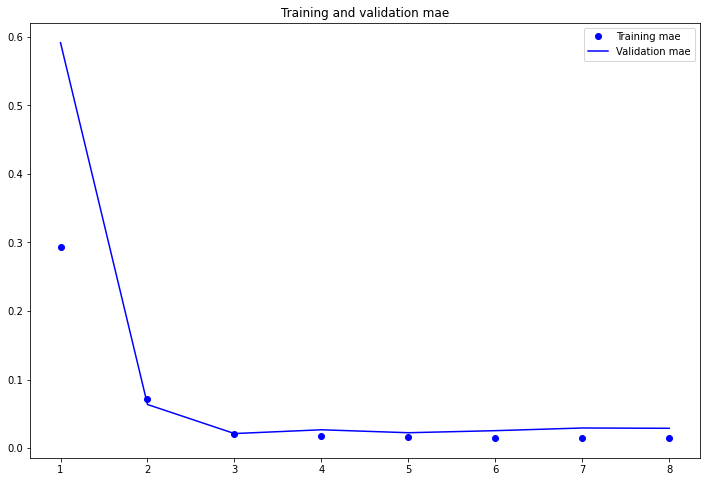

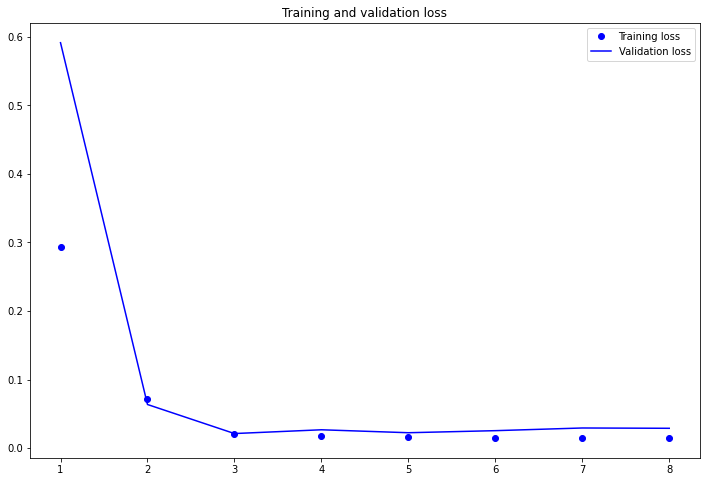

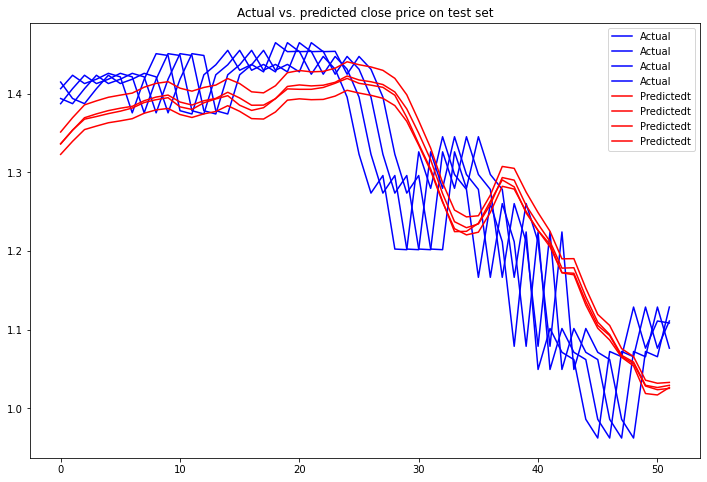

In [0]:
# LSTM model with attention layer
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(64, recurrent_dropout=0.5, return_sequences=True), input_shape=(n_steps_in, n_features)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(layers.Flatten())
model.add(layers.Dense(n_steps_out))
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='42'></a>
### Step 4.2: Developing a 1-to-4 Model

1-to-4 MLP:

Normalized base line MAE on validation data: 0.019257637079186606
Original base line MAE on validation data: 3.9407729408957777
Normalized base line MAE on test data: 0.05144854655445024
Original base line MAE on test data: 10.528136929598723
55/55 [==============================] - 0s 125us/step
Validation MAE: 0.06698223203420639
55/55 [==============================] - 0s 93us/step
Original validation MAE: 13.706861669258956
55/55 [==============================] - 0s 103us/step
Test MAE: 0.07521258294582367
55/55 [==============================] - 0s 69us/step
Original test MAE: 15.39107370592842


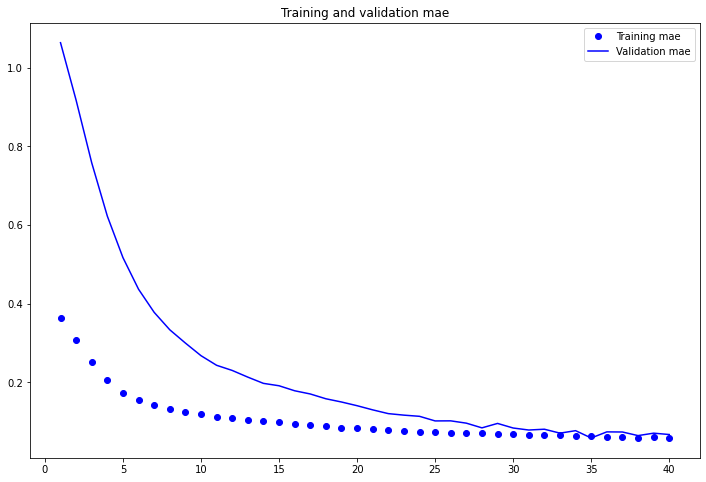

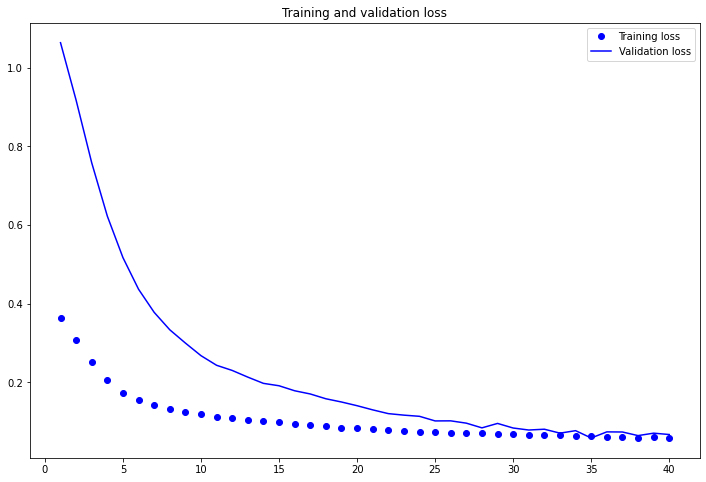

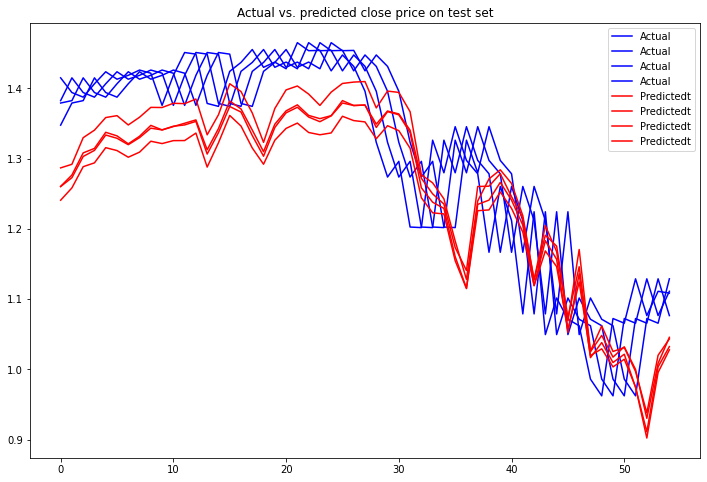

1-to-4 GRU:

Normalized base line MAE on validation data: 0.019257637079186606
Original base line MAE on validation data: 3.9407729408957777
Normalized base line MAE on test data: 0.05144854655445024
Original base line MAE on test data: 10.528136929598723
55/55 [==============================] - 0s 127us/step
Validation MAE: 0.01878557913005352
55/55 [==============================] - 0s 89us/step
Original validation MAE: 3.8441736964075233
55/55 [==============================] - 0s 107us/step
Test MAE: 0.049997806549072266
55/55 [==============================] - 0s 79us/step
Original test MAE: 10.231265774847998


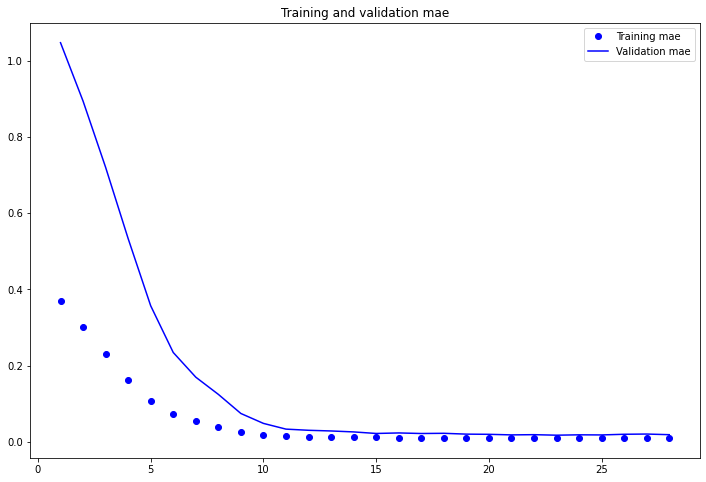

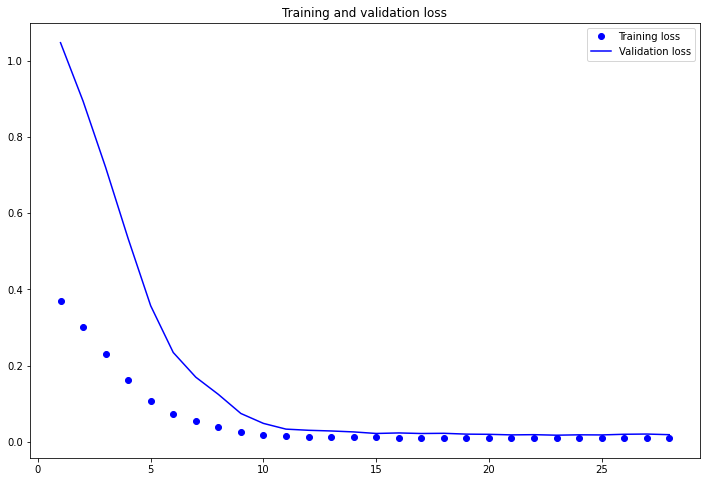

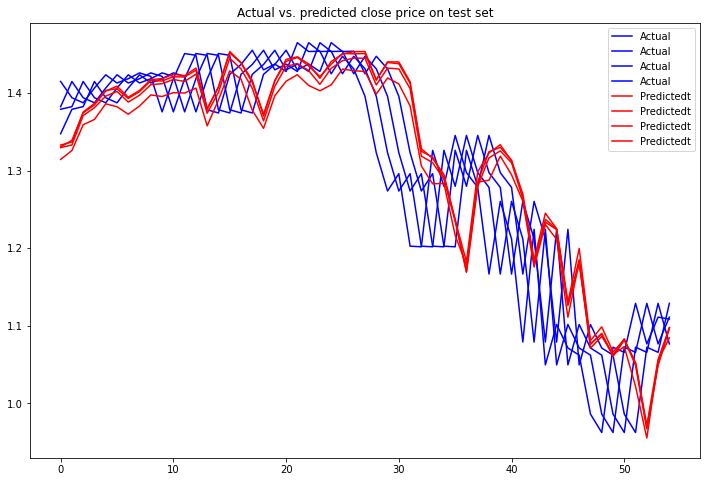

1-to-4 LSTM:

Normalized base line MAE on validation data: 0.019257637079186606
Original base line MAE on validation data: 3.9407729408957777
Normalized base line MAE on test data: 0.05144854655445024
Original base line MAE on test data: 10.528136929598723
55/55 [==============================] - 0s 116us/step
Validation MAE: 0.033338990062475204
55/55 [==============================] - 0s 90us/step
Original validation MAE: 6.822300647517693
55/55 [==============================] - 0s 200us/step
Test MAE: 0.08648393303155899
55/55 [==============================] - 0s 87us/step
Original test MAE: 17.697578457398436


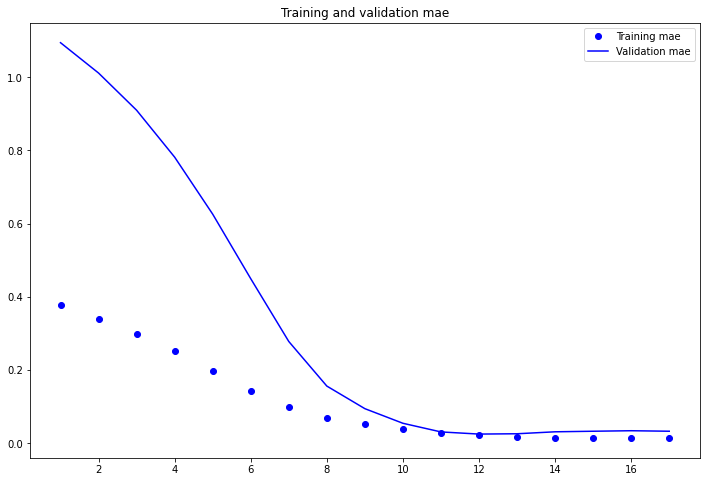

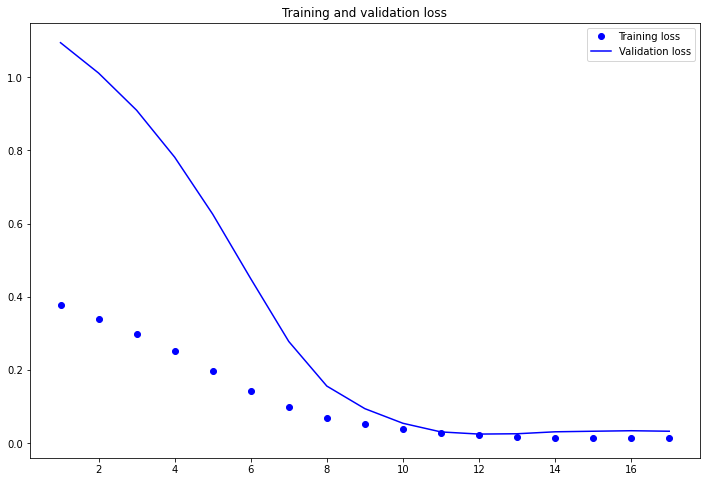

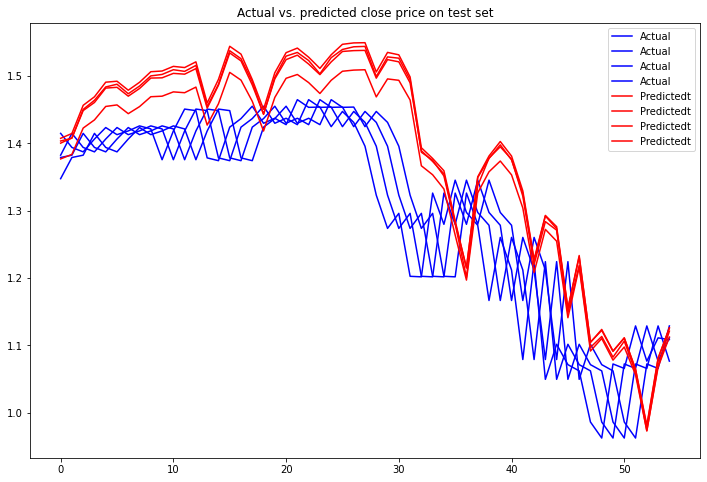

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 1, 128)            26880     
_________________________________________________________________
seq_self_attention_9 (SeqSel (None, 1, 128)            8257      
_________________________________________________________________
flatten_14 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 516       
Total params: 35,653
Trainable params: 35,653
Non-trainable params: 0
_________________________________________________________________
1-to-4 GRU with Attention:

Normalized base line MAE on validation data: 0.019257637079186606
Original base line MAE on validation data: 3.9407729408957777
Normalized base line MAE on test data: 0.05144854655445024
Original base line MAE on test d

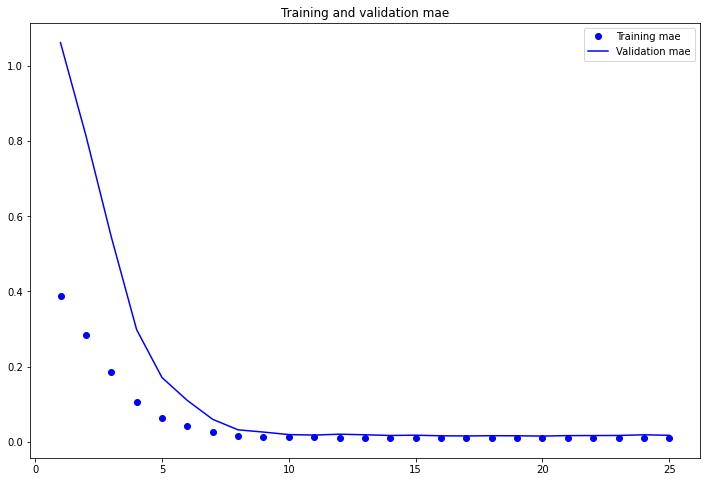

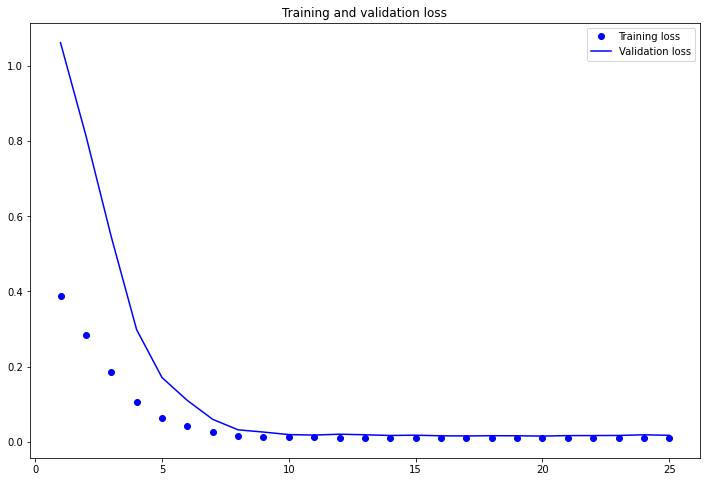

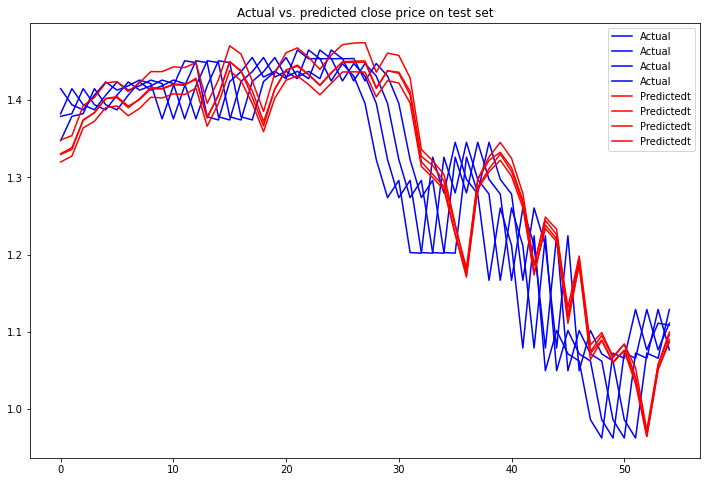

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 1, 128)            35840     
_________________________________________________________________
seq_self_attention_10 (SeqSe (None, 1, 128)            8257      
_________________________________________________________________
flatten_15 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 516       
Total params: 44,613
Trainable params: 44,613
Non-trainable params: 0
_________________________________________________________________
1-to-4 LSTM with Attention:

Normalized base line MAE on validation data: 0.019257637079186606
Original base line MAE on validation data: 3.9407729408957777
Normalized base line MAE on test data: 0.05144854655445024
Original base line MAE on test 

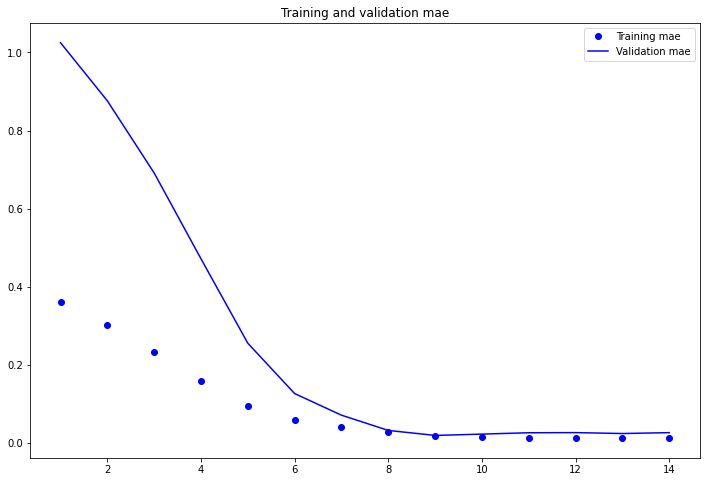

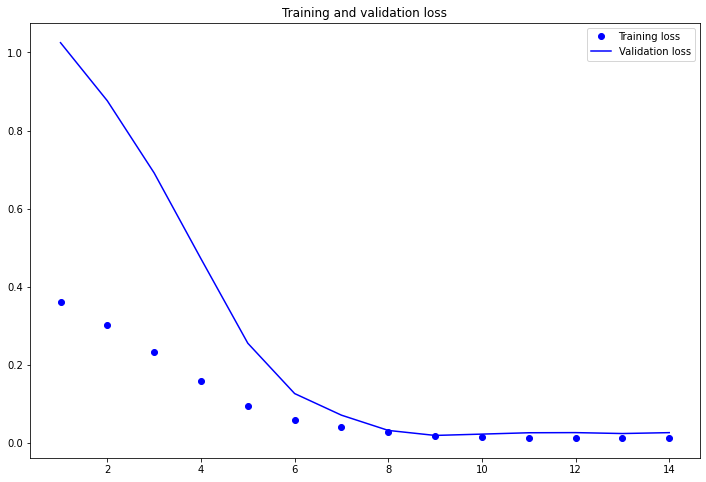

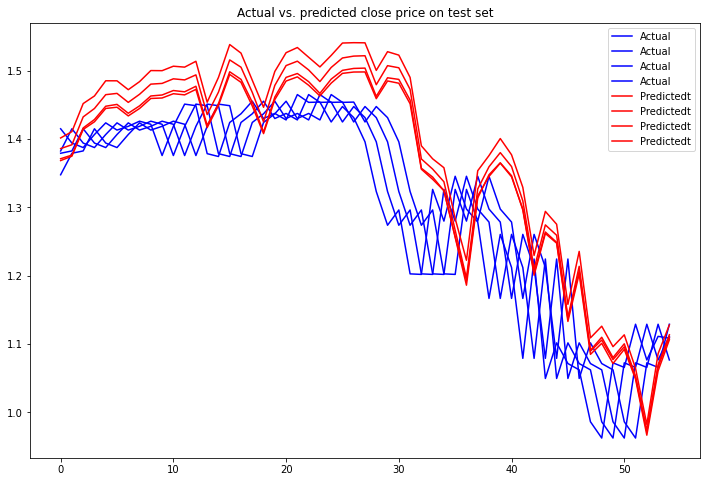

In [0]:
# Prepare the data for 1-to-4 model
n_steps_in, n_steps_out, n_features = 1, 4, 5
X_train, y_train = split_sequence_mtm(train_data, n_steps_in, n_steps_out)
X_valid, y_valid = split_sequence_mtm(valid_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence_mtm(test_data, n_steps_in, n_steps_out)

# MLP model
model = Sequential()
model.add(layers.Flatten(input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)], verbose=0)

print('1-to-4 MLP:')
eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)], verbose=0)

print('1-to-4 GRU:')
eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

# LSTM model
model = Sequential()
model.add(layers.LSTM(64, recurrent_dropout=0.5, input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)], verbose=0)

print('1-to-4 LSTM:')
eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

# GRU model with attention layer
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(64, recurrent_dropout=0.4, return_sequences=True), input_shape=(n_steps_in, n_features)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(layers.Flatten())
model.add(layers.Dense(n_steps_out))
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)], verbose=0)

print('1-to-4 GRU with Attention:')
eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

# LSTM model with attention layer
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(64, recurrent_dropout=0.5, return_sequences=True), input_shape=(n_steps_in, n_features)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(layers.Flatten())
model.add(layers.Dense(n_steps_out))
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)], verbose=0)

print('1-to-4 LSTM with Attention:')
eval_mae_mtm(model, scaler, n_steps_out, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='43'></a>
### Step 4.3: Optimizing GRU Model

Train on 2451 samples, validate on 52 samples
Epoch 1/200
2451/2451 [==============================] - 2s 994us/step - loss: 0.2226 - mae: 0.2226 - val_loss: 0.5707 - val_mae: 0.5707
Epoch 2/200
2451/2451 [==============================] - 2s 709us/step - loss: 0.0842 - mae: 0.0842 - val_loss: 0.4136 - val_mae: 0.4136
Epoch 3/200
2451/2451 [==============================] - 2s 762us/step - loss: 0.0640 - mae: 0.0640 - val_loss: 0.3517 - val_mae: 0.3517
Epoch 4/200
2451/2451 [==============================] - 2s 678us/step - loss: 0.0580 - mae: 0.0580 - val_loss: 0.3243 - val_mae: 0.3243
Epoch 5/200
2451/2451 [==============================] - 2s 748us/step - loss: 0.0551 - mae: 0.0551 - val_loss: 0.3059 - val_mae: 0.3059
Epoch 6/200
2451/2451 [==============================] - 2s 663us/step - loss: 0.0515 - mae: 0.0515 - val_loss: 0.2992 - val_mae: 0.2992
Epoch 7/200
2451/2451 [==============================] - 2s 692us/step - loss: 0.0493 - mae: 0.0493 - val_loss: 0.2880 - val_mae: 0.

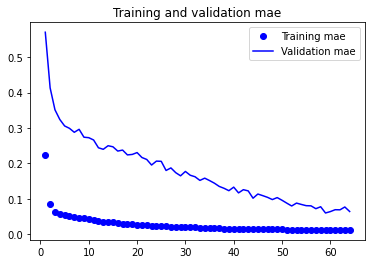

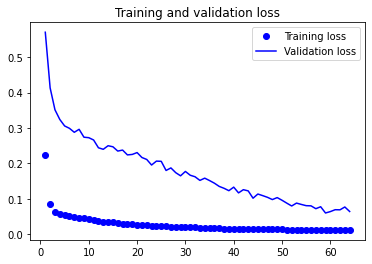

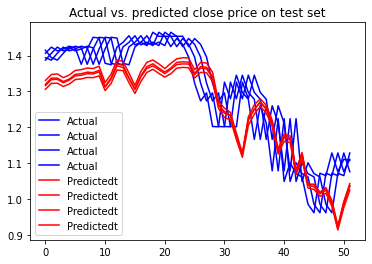

In [0]:
# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(layers.GRU(32, recurrent_dropout=0.4))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, validation_data=[X_valid, y_valid], callbacks=[EarlyStopping(patience=5)])

eval_mae_mtm(model, scaler, n_steps_in, X_valid, y_valid, X_test, y_test)
plot_model(history, model, X_test, y_test)

<a id='4'></a>
### Step 4.4: Best Many-to-Many GRU Model with Four Days Lags & Four Days Delays






In [0]:
def load_data_mtm(ticker='AAPL', start=datetime.date(2010, 1, 1), 
                  end=datetime.date.today(),  n_steps_in=4, n_steps_out=4):
  """
  Load the ticker data from start date to end date.
  Transform and normalize the dataset.
  """
  df = load_stock(ticker, start, end)
  data = df.drop(['Date', 'Adj Close'], axis=1)
  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)
  X_train, y_train = split_sequence_mtm(data, n_steps_in, n_steps_out)

  return scaler, X_train, y_train

n_steps_in, n_steps_out, n_features = 4, 4, 5
scaler, X_train, y_train = load_data_mtm()

# GRU model
model = Sequential()
model.add(layers.GRU(64, recurrent_dropout=0.4, input_shape=(n_steps_in, n_features)))
model.add(layers.Dense(n_steps_out))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=69, verbose=0)

y_pred = model.predict(X_train[-1:, :, :])
print('Predicted price on the following {} days starting from {}: {}'.format(n_steps_out, datetime.date.today(), y_pred * scaler.data_range_[3] + scaler.data_min_[3]))

Predicted price on the following 4 days starting from 2020-04-25: [[277.44388 279.77917 271.14545 273.87646]]


<a id='5'></a>
## Step 5: Putting All Together

In [0]:
# Intall pandas_datareader
!pip -q install pandas_datareader
!pip -q install keras-self-attention

# Import necessary libraries
import pandas_datareader.data as web
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention

import warnings
warnings.filterwarnings('ignore')


class GRURegressor:
  """
  Author: Christopher W. Hong
          Zhenghao Zhao
  Data: 2020.04.21

  This class implement a many to many RNN regressor with GRU units.
  """
  
  def __init__(self, ticker_name='AAPL', 
               start_date=datetime.datetime(2010,1,1), 
               end_date=datetime.datetime.today().date() - datetime.timedelta(days=1),
               n_steps_in=4,
               n_steps_out=4,
               test_size=0.05):
    self.ticker_name = ticker_name
    self.start_date = start_date
    self.end_date = end_date
    self.n_steps_in = n_steps_in
    self.n_steps_out = n_steps_out
    self.test_size= test_size

    assert start_date.date() <= end_date
    assert n_steps_in >= 1
    assert n_steps_out >= 1

  def load_stock(self):
    """
    Load ticker from start date till end date into a DataFrame.
    """
    df = web.DataReader(self.ticker_name, 'yahoo', self.start_date , self.end_date)
    df = df.reset_index()
    df = df.drop(['Date', 'Adj Close'], axis=1)
    return df

  def split_data(self, data):
    """
    Split the data into train & test set.
    """
    self.n_features = data.shape[1]
    data_size = len(data)
    self.train_idx = int((data_size) * (1 - self.test_size))
    data = data.values
    train_data = data[:self.train_idx, :]
    test_data = data[self.train_idx:, :]
    return train_data, test_data

  def normalize_data(self, train_data, test_data):
    """
    Normalize the data.
    """
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    self.data_range = np.array([scaler.data_range_[3]])
    self.data_min = np.array([scaler.data_min_[3]])
    return train_data, test_data

  def split_sequence(self, data):
    """
    Split a sequence into arbitrary many to many shape.
    """
    X, Y = [], []
    for i in np.arange(len(data)):
      input_end_idx = i + self.n_steps_in
      output_end_idx = input_end_idx + self.n_steps_out
      # Check if the idx is out of bound
      if output_end_idx > len(data) - 1:
        break
      x, y = data[i:input_end_idx, :], data[input_end_idx:output_end_idx, 3]
      X.append(x)
      Y.append(y)
    return np.array(X), np.array(Y)

  def load_data(self):
    """
    Load the data into ready-to-train and test format.
    """
    df = self.load_stock()
    train_data, test_data = self.split_data(df)
    train_data, test_data = self.normalize_data(train_data, test_data)
    X_train, y_train = self.split_sequence(train_data)
    X_test, y_test = self.split_sequence(test_data)
    return X_train, X_test, y_train, y_test

  def fit(self, X_train, y_train, n_units=64, dropout=0.4, epochs=69, verbose=0):
    """
    Train the GRU model.
    """
    self.model = Sequential()
    self.model.add(layers.GRU(n_units, recurrent_dropout=dropout, 
                         input_shape=(self.n_steps_in, self.n_features)))
    self.model.add(layers.Dense(self.n_steps_out))
    self.model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
    history = self.model.fit(X_train, y_train, epochs=69, verbose=verbose)
    return history

  def fit_withattention(self, X_train, y_train, n_units=64, dropout=0.4, epochs=69, verbose=0):
    """
    Train the GRU model with attention layer.
    """
    self.model = Sequential()
    model.add(layers.GRU(64, recurrent_dropout=0.5, input_shape=(n_steps, n_features), return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(layers.Flatten())
    self.model.add(layers.Dense(self.n_steps_out))
    self.model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])
    history = self.model.fit(X_train, y_train, epochs=69, verbose=verbose)
    return history

  def evaluate(self, X_test, y_test):
    """
    Evaluate the loss and mae.
    """
    return self.model.evaluate(X_test, y_test)[1] * self.data_range

  def predict(self, X_test):
    """
    Make predictions on X_test.
    """
    return self.model.predict(X_test) * self.data_range + self.data_min

  def plot(self, y_test, y_preds):
    """
    Plot the true targets against the predicted ones.
    """
    y_test = y_test * self.data_range + self.data_min
    if self.n_steps_out > 1:
      for i in np.arange(self.n_steps_out):
        plt.plot(y_test[:, i], 'b', label='Actual')
        plt.plot(y_preds[:, i], 'r', label='Predicted')
        plt.title('Actual vs. Predicted Close Price @ Day ' + str(i+1))
        plt.legend()
        plt.show();
      plt.plot(y_test, 'b', label='Actual')
      plt.plot(y_preds, 'r', label='Predicted')
      plt.title('Actual vs. Predicted Close Price')
      plt.legend()
      plt.show();
    else:
        plt.plot(y_test, 'b', label='Actual')
        plt.plot(y_preds, 'r', label='Predicted')
        plt.title('Actual vs. Predicted Close Price')
        plt.legend()
        plt.show();

X_train shape: (2460, 4, 5)
X_test shape: (125, 4, 5)
y_train shape: (2460, 1)
y_test shape: (125, 1)
125/125 [==============================] - 0s 646us/step
MAE on test set: [5.72667723]


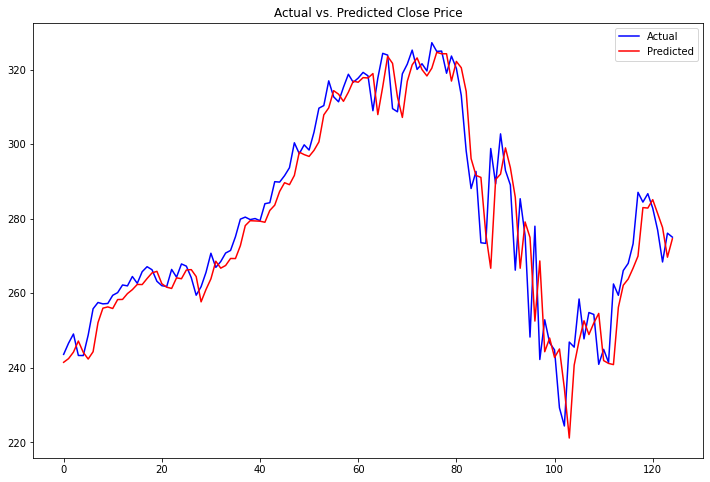

X_train shape: (2463, 1, 5)
X_test shape: (128, 1, 5)
y_train shape: (2463, 1)
y_test shape: (128, 1)
128/128 [==============================] - 0s 487us/step
MAE on test set: [7.08657926]


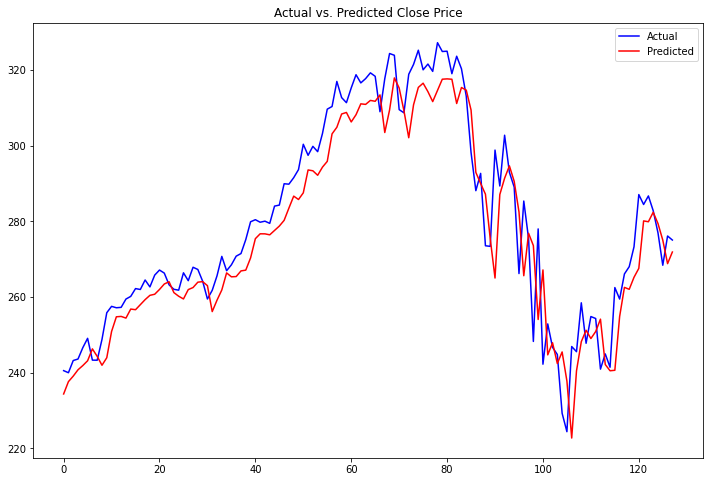

X_train shape: (2459, 1, 5)
X_test shape: (124, 1, 5)
y_train shape: (2459, 5)
y_test shape: (124, 5)
124/124 [==============================] - 0s 529us/step
MAE on test set: [9.81421598]


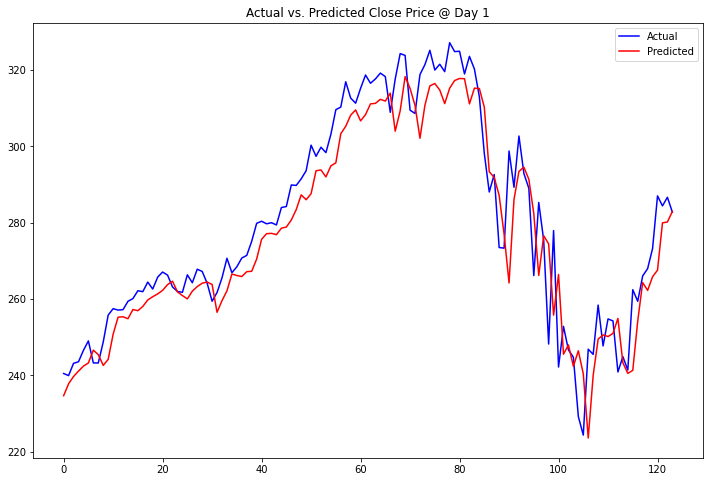

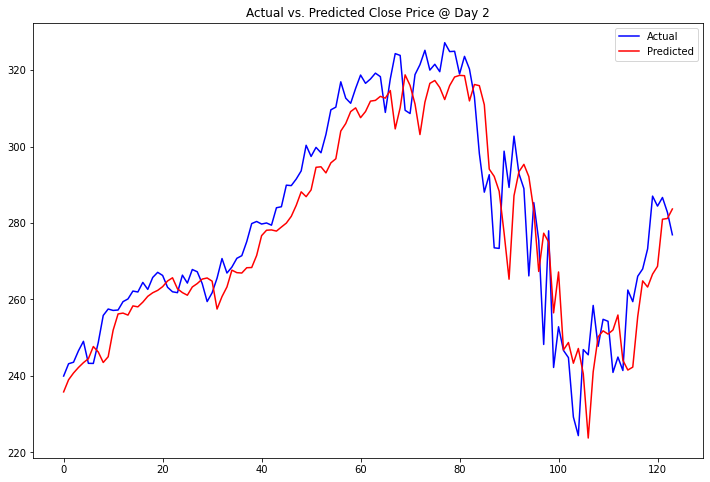

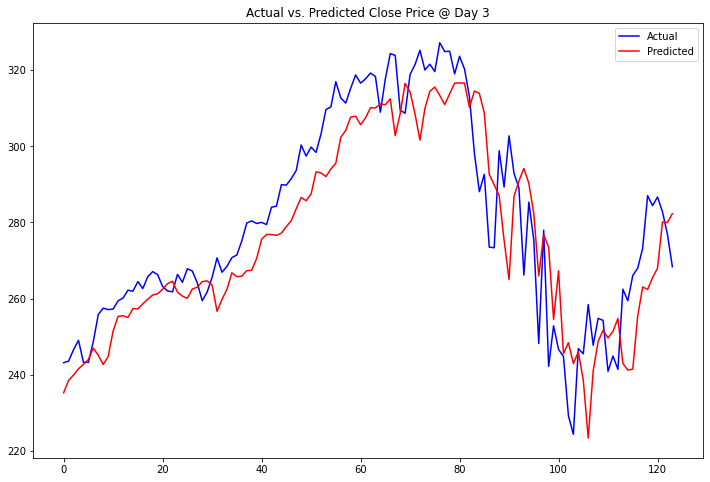

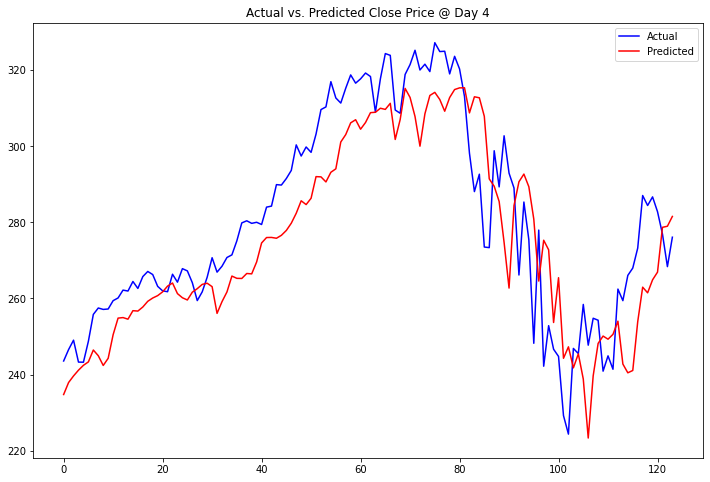

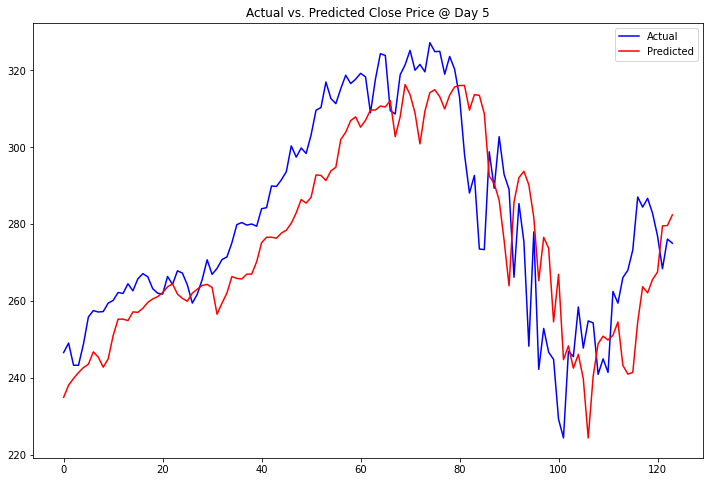

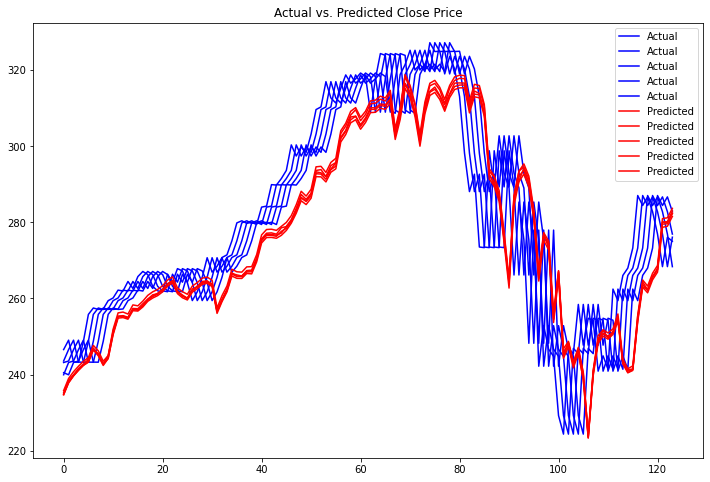

X_train shape: (2455, 5, 5)
X_test shape: (120, 5, 5)
y_train shape: (2455, 5)
y_test shape: (120, 5)
120/120 [==============================] - 0s 699us/step
MAE on test set: [21.57818384]


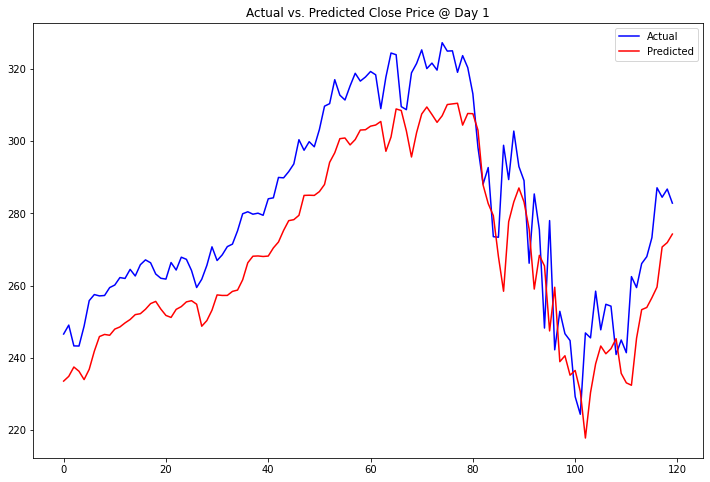

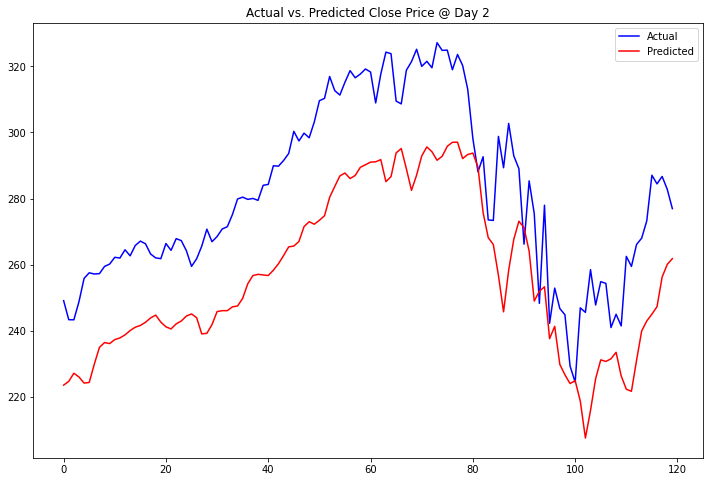

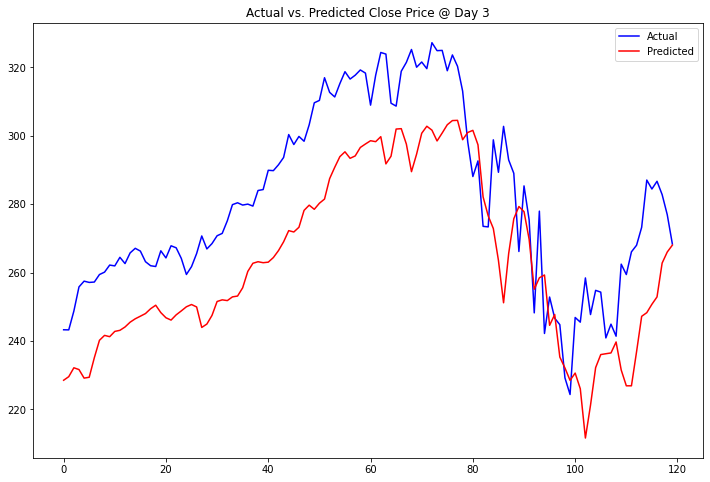

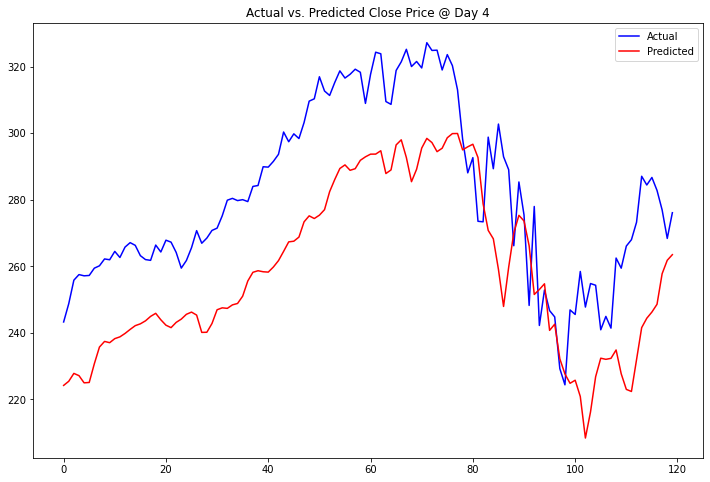

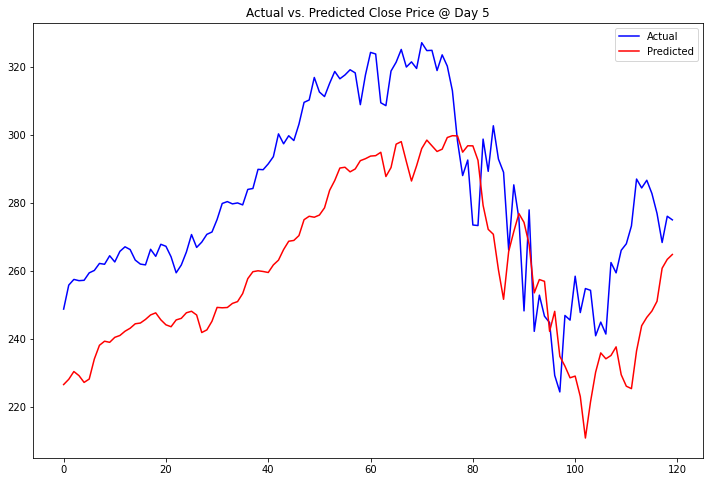

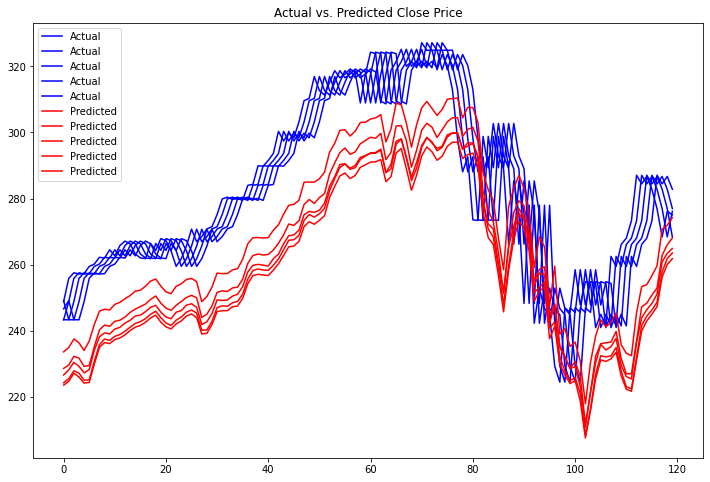

In [0]:
for i in [[4, 1], [1, 1], [1, 5], [5, 5]]:
  n_steps_in, n_steps_out = i[0], i[1]
  model = GRURegressor(n_steps_in=n_steps_in, n_steps_out=n_steps_out)

  # Load train and test datasets
  X_train, X_test, y_train, y_test = model.load_data()
  print('X_train shape:', X_train.shape)
  print('X_test shape:', X_test.shape)
  print('y_train shape:', y_train.shape)
  print('y_test shape:', y_test.shape)

  history = model.fit(X_train, y_train)

  # Evaluate MAE
  print('MAE on test set:', model.evaluate(X_test, y_test))

  # Make predictions
  y_preds = model.predict(X_test)

  # Plot actual vs. predicted
  model.plot(y_test, y_preds)

## References

B. Overland & J. Bennett. 2020. Supercharged Python. Boston, MA. Pearson Education, Inc

J. Brownlee. 2018. Deep Learning for Time Series Forecasting (1.4 ed.). 

T. Ganegedara. 2020. Stock Market Predictions with LSTM in Python. Retrieved from https://www.datacamp.com/community/tutorials/lstm-python-stock-market